# Surgical Capacity and Waiting Times for Planned Surgeries in Denmark  
*A Regional and Temporal Analysis Based in 2020-2025* 

# Problem Statement
**How does the capacity of _surgical_ hospital beds (available/normed) and surgical activity affect waiting times for planned surgery in the five Danish regions?**

---

## Sub-questions

### Development over time (surgery)
- How has the number of **surgically available** and **surgically normed** beds changed over time per region?
- Are there **seasonal fluctuations** in capacity, waiting-time buckets, and number of surgeries?

### Comparison of regions (surgery)
- Which regions have the highest/lowest **surgical capacity level**, and how has the development been?
- Which regions have **shorter waiting times relative to capacity** (e.g., waiting list per 100 surgically available beds)?

### Relationship between waiting time and capacity/activity (surgery)
- Is there a **correlation** between **surgically available beds** and the number of patients in waiting-time buckets (0–30, 31–60, 61–90, 90+ days)?
- Is **more surgically available beds** and/or **higher surgical activity** associated with **shorter waiting times**?

### Statistical analyses / models (surgery)
- Can a **(multi)linear regression** predict the waiting list / 90+ share based on **surgical capacity** and **surgical activity** (with month/region controls)?
- Can a **classification model** identify months with **high load** (e.g., top-25% 90+ waiting time)?  
  (Evaluated with **confusion matrix**, accuracy/F1.)
- Do **correlation heatmaps, tree models, clusters,** and **3D visualizations** provide consistent patterns?

In [1]:
# Use `src/hosp_dataloader.py` to load the surgical datasets.

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

In [2]:
# Import the hosp_dataloader module and preview the datasets (loaded as pandas DataFrames)

import hosp_dataloader as hd
from IPython.display import display

kir_op = hd.kir_op
kir_sp = hd.kir_sp
kir_vt = hd.kir_vt

display(kir_op.head())
display(kir_sp.head())
display(kir_vt.head())

,Region,År,Måned,Kirurgi_Operationer_total
0,Region Hovedstaden,2015,1,5143
1,Region Hovedstaden,2015,2,5139
2,Region Hovedstaden,2015,3,5636
3,Region Hovedstaden,2015,4,5507
4,Region Hovedstaden,2015,5,5091


,Region,År,Måned,Disponible_senge,Normerede_senge,Belægningsgrad_disponible,Belægningsgrad_normerede,Patienter_total
0,Region Hovedstaden,2014,1,1631.0,1662.0,81.0,79.0,40895.0
1,Region Hovedstaden,2014,2,1602.0,1651.0,81.0,79.0,36503.0
2,Region Hovedstaden,2014,3,1641.0,1659.0,80.0,79.0,40555.0
3,Region Hovedstaden,2014,4,1580.0,1629.0,79.0,77.0,37499.0
4,Region Hovedstaden,2014,5,1629.0,1656.0,78.0,76.0,39248.0


,Region,År,Måned,Kirurgi_Ventetid_0_30_dage,Kirurgi_Ventetid_31_60_dage,Kirurgi_Ventetid_61_90_dage,Kirurgi_Ventetid_90_plus_dage,Kirurgi_Venteliste_total
0,Region Hovedstaden,2020,1,510,248,225,268,1251
1,Region Hovedstaden,2020,2,510,248,225,268,1251
2,Region Hovedstaden,2020,3,509,247,225,267,1248
3,Region Hovedstaden,2020,4,335,76,99,295,805
4,Region Hovedstaden,2020,5,334,76,99,295,804


## Explanation
- `kir_op`: Surgical operations by region/year/month  
- `kir_sp`: Surgical bed capacity (available vs. normed) by region/year/month  
- `kir_vt`: Waiting-time buckets (0–30, 31–60, 61–90, 90+ days) by region/year/month  

In [3]:
# Show the size of each DataFrame (number of rows and columns)

for name, df in [("operations", kir_op), ("beds", kir_sp), ("waiting", kir_vt)]:
    print(f"{name}: {df.shape}")

operations: (600, 4)
beds: (690, 8)
waiting: (330, 8)


In [4]:
# Apply the cleaning function from hosp_clean.py to each dataset 
# so they have consistent columns, valid year/month, and a proper 'Dato' column

import hosp_clean as hc

kir_op_cleaned = hc.clean(kir_op)
kir_sp_cleaned = hc.clean(kir_sp)
kir_vt_cleaned = hc.clean(kir_vt)

In [5]:
# Display dataset structure (.info) for operations, beds, and waiting,
# with section headers to make the outputs easy to distinguish

In [6]:
print("=== Operations ===")
kir_op_cleaned.info()

=== Operations ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Dato                       600 non-null    datetime64[ns]
 1   Region                     600 non-null    object        
 2   År                         600 non-null    int64         
 3   Måned                      600 non-null    int64         
 4   Kirurgi_Operationer_total  600 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 23.6+ KB


In [7]:
print("\n=== Beds ===")
kir_sp_cleaned.info()


=== Beds ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Dato                       690 non-null    datetime64[ns]
 1   Region                     690 non-null    object        
 2   År                         690 non-null    int64         
 3   Måned                      690 non-null    int64         
 4   Disponible_senge           666 non-null    float64       
 5   Normerede_senge            666 non-null    float64       
 6   Belægningsgrad_disponible  666 non-null    float64       
 7   Belægningsgrad_normerede   666 non-null    float64       
 8   Patienter_total            666 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 48.6+ KB


In [8]:
print("\n=== Waiting ===")
kir_vt_cleaned.info()


=== Waiting ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Dato                           330 non-null    datetime64[ns]
 1   Region                         330 non-null    object        
 2   År                             330 non-null    int64         
 3   Måned                          330 non-null    int64         
 4   Kirurgi_Ventetid_0_30_dage     330 non-null    int64         
 5   Kirurgi_Ventetid_31_60_dage    330 non-null    int64         
 6   Kirurgi_Ventetid_61_90_dage    330 non-null    int64         
 7   Kirurgi_Ventetid_90_plus_dage  330 non-null    int64         
 8   Kirurgi_Venteliste_total       330 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 23.3+ KB


In [9]:
# Merge ops, beds, and waiting on Region+Dato; rebuild a single År/Måned from Dato and drop duplicate time columns

import pandas as pd

def merge_all(kir_op_cleaned, kir_sp_cleaned, kir_vt_cleaned):
    df = (kir_op_cleaned
            .merge(kir_sp_cleaned, on=["Region","Dato"], how="inner", suffixes=("_op","_beds"))
            .merge(kir_vt_cleaned, on=["Region","Dato"], how="inner", suffixes=("", "_wait")))

    df["År"] = pd.to_datetime(df["Dato"]).dt.year
    df["Måned"] = pd.to_datetime(df["Dato"]).dt.month

    dup_cols = [c for c in df.columns
                if (c.startswith("År") or c.startswith("Måned")) and c not in ("År", "Måned")]
    df = df.drop(columns=dup_cols)

    return df

all_kir_cleaned = merge_all(kir_op_cleaned, kir_sp_cleaned, kir_vt_cleaned)

display(all_kir_cleaned)

,Dato,Region,Kirurgi_Operationer_total,Disponible_senge,Normerede_senge,Belægningsgrad_disponible,Belægningsgrad_normerede,Patienter_total,År,Måned,Kirurgi_Ventetid_0_30_dage,Kirurgi_Ventetid_31_60_dage,Kirurgi_Ventetid_61_90_dage,Kirurgi_Ventetid_90_plus_dage,Kirurgi_Venteliste_total
0,2020-01-01,Region Syddanmark,3592,671.0,675.0,77.0,76.0,15927.0,2020,1,323,241,153,147,864
1,2020-01-01,Region Nordjylland,1621,302.0,329.0,95.0,87.0,8893.0,2020,1,146,96,49,37,328
2,2020-01-01,Region Hovedstaden,4960,1501.0,1584.0,67.0,64.0,31201.0,2020,1,510,248,225,268,1251
3,2020-01-01,Region Sjælland,2115,413.0,443.0,74.0,69.0,9455.0,2020,1,201,153,94,156,604
4,2020-01-01,Region Midtjylland,3758,710.0,741.0,81.0,78.0,17906.0,2020,1,442,260,124,96,922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2024-12-01,Region Sjælland,2295,345.0,442.0,80.0,63.0,8608.0,2024,12,357,175,107,161,800
296,2024-12-01,Region Midtjylland,3591,572.0,646.0,77.0,68.0,13668.0,2024,12,653,317,130,186,1286
297,2024-12-01,Region Hovedstaden,5233,1057.0,1353.0,67.0,53.0,22044.0,2024,12,600,369,176,265,1410
298,2024-12-01,Region Nordjylland,1631,277.0,321.0,78.0,68.0,6726.0,2024,12,366,166,57,65,654


In [10]:
# Import the custom histogram function and matplotlib for styling
from hosp_hist import plot_hosp_histogram
import matplotlib.pyplot as plt

# Set global style for cleaner and more consistent visuals
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12

# Define the region column name (makes it easier to change later if needed)
REGION_COL = "Region"

In [11]:
# These derived metrics make the histograms more meaningful for analysis.
# They represent workload, efficiency, and pressure on hospital capacity.

# Patients per available bed: how many patients each available bed "supports"
all_kir_cleaned["Patienter_pr_disponibel_seng"] = (
    all_kir_cleaned["Patienter_total"] / all_kir_cleaned["Disponible_senge"]
)

# Surgeries per available bed: how much surgical activity each bed handles
all_kir_cleaned["Operationer_pr_disponibel_seng"] = (
    all_kir_cleaned["Kirurgi_Operationer_total"] / all_kir_cleaned["Disponible_senge"]
)

# Waiting list per 100 available beds: standardizes waiting list size relative to capacity
all_kir_cleaned["Venteliste_pr_100_disponible"] = (
    100 * all_kir_cleaned["Kirurgi_Venteliste_total"] / all_kir_cleaned["Disponible_senge"]
)

# Get a list of all regions to iterate through
regions = sorted(all_kir_cleaned[REGION_COL].dropna().unique())
regions

['Region Hovedstaden',
 'Region Midtjylland',
 'Region Nordjylland',
 'Region Sjælland',
 'Region Syddanmark']

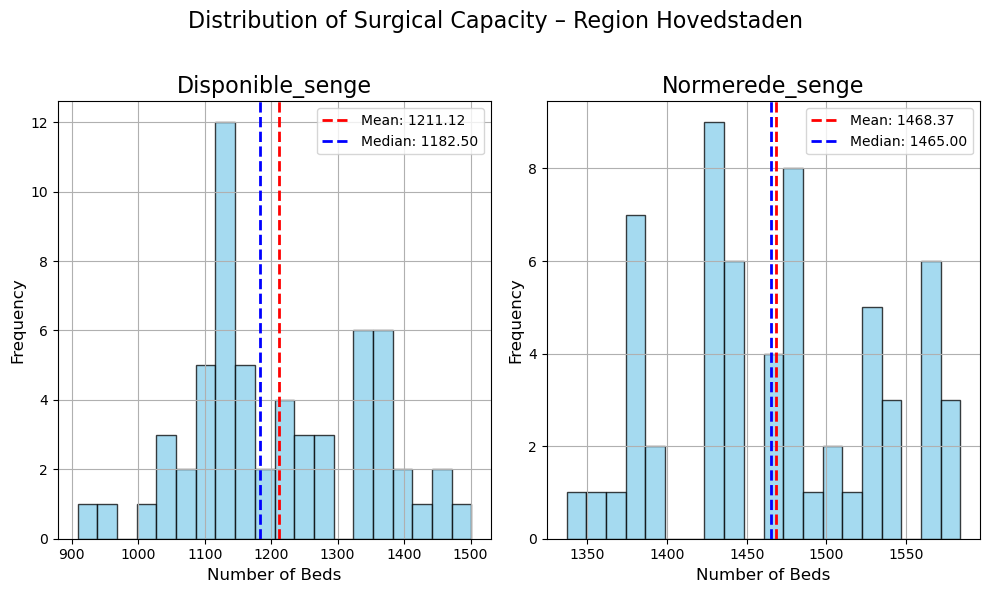

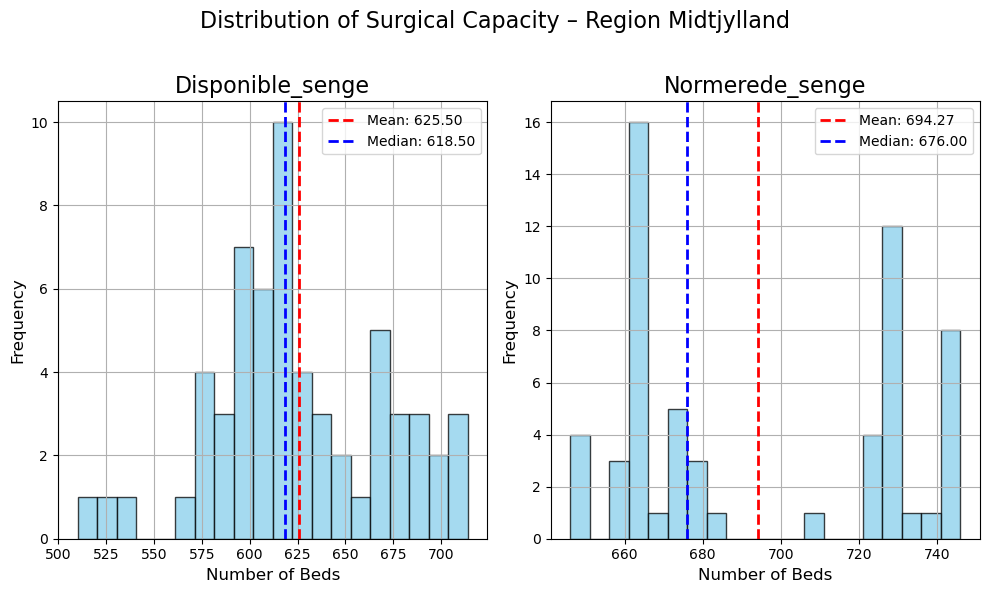

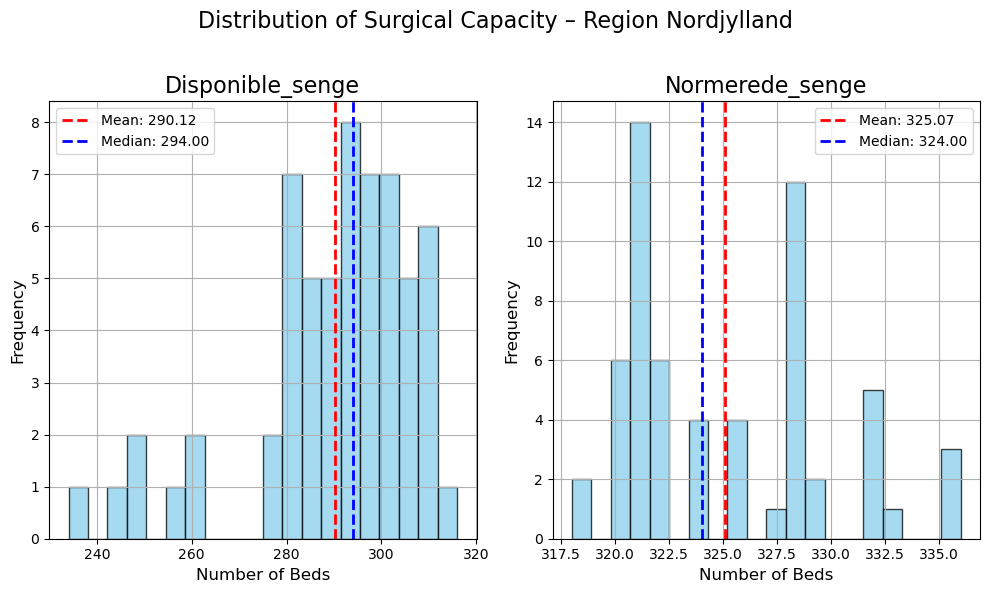

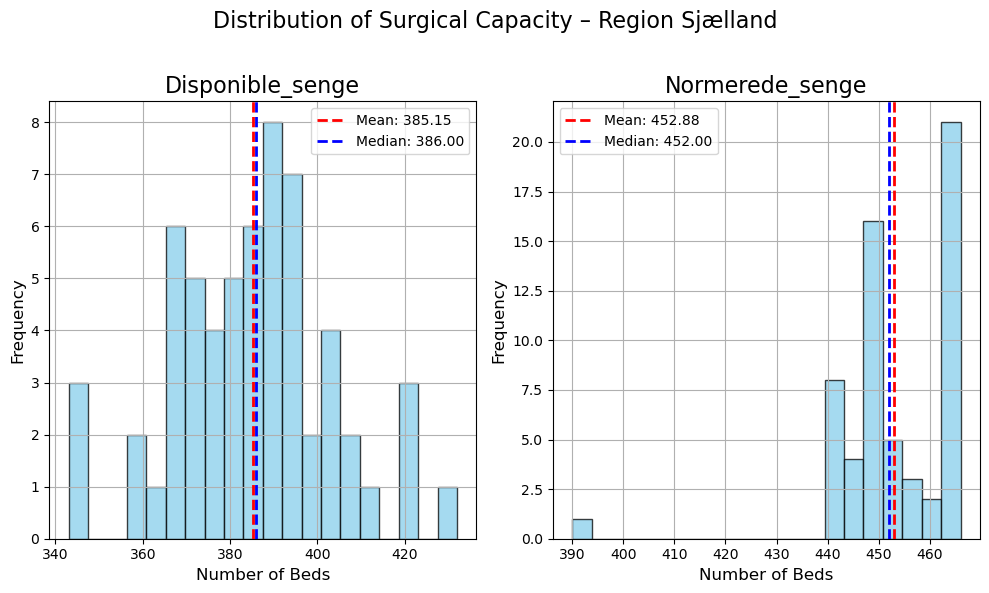

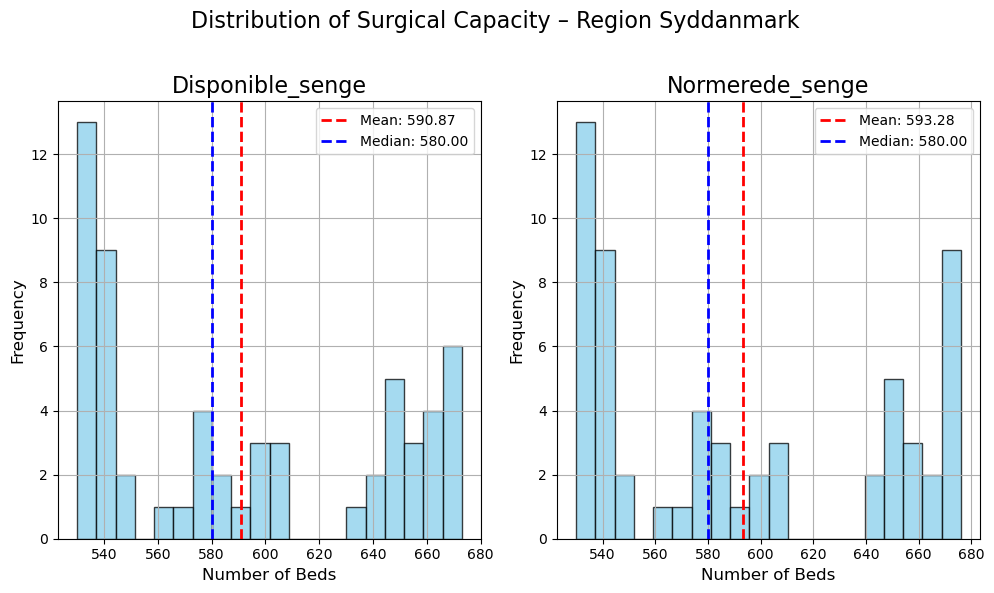

In [12]:
# These histograms show the distribution of available and normed surgical beds per region.
# Useful for seeing whether some regions consistently have higher or lower capacity.

for r in regions:
    sub = all_kir_cleaned[all_kir_cleaned[REGION_COL] == r]
    plot_hosp_histogram(
        sub[["Disponible_senge", "Normerede_senge"]],
        title=f"Distribution of Surgical Capacity – {r}",
        x_label="Number of Beds",
        y_label="Frequency",
        color="skyblue",
        show_skewer=True,
    )

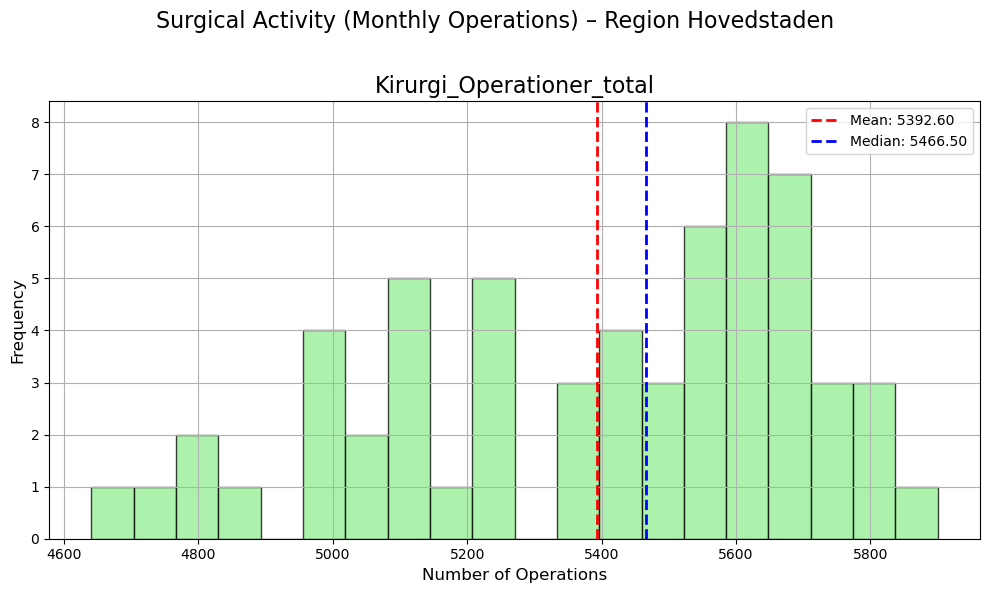

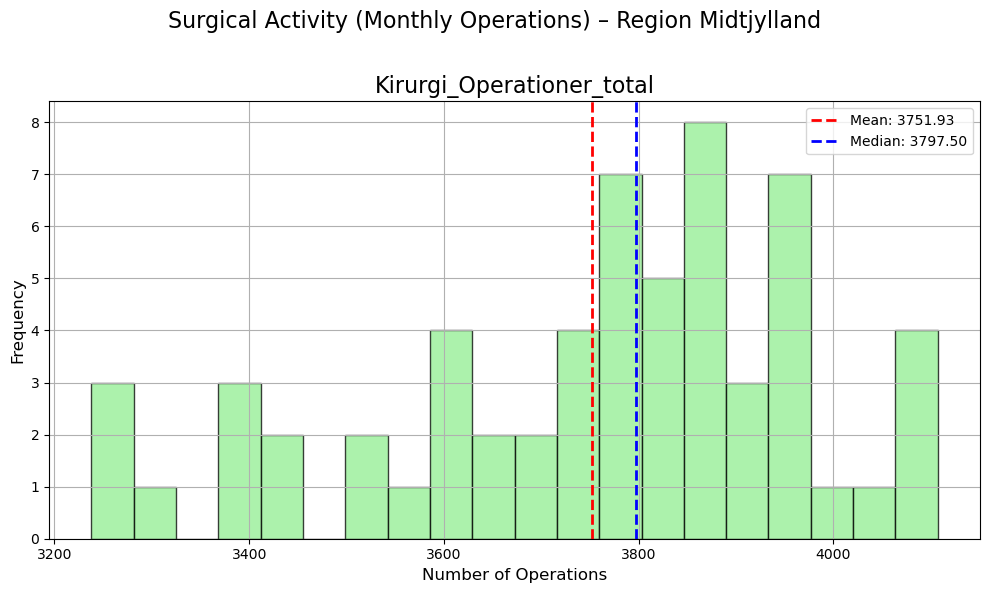

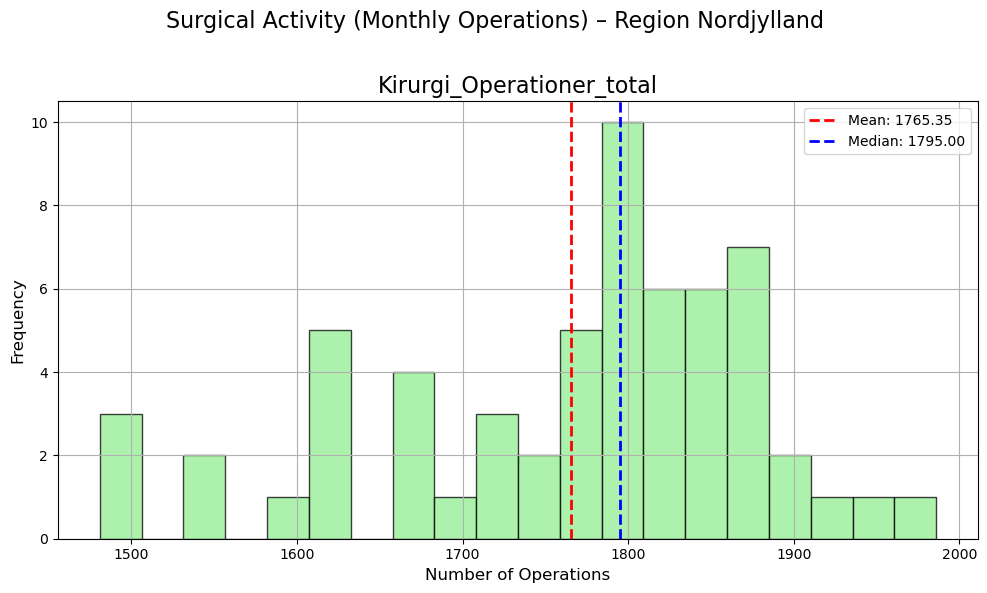

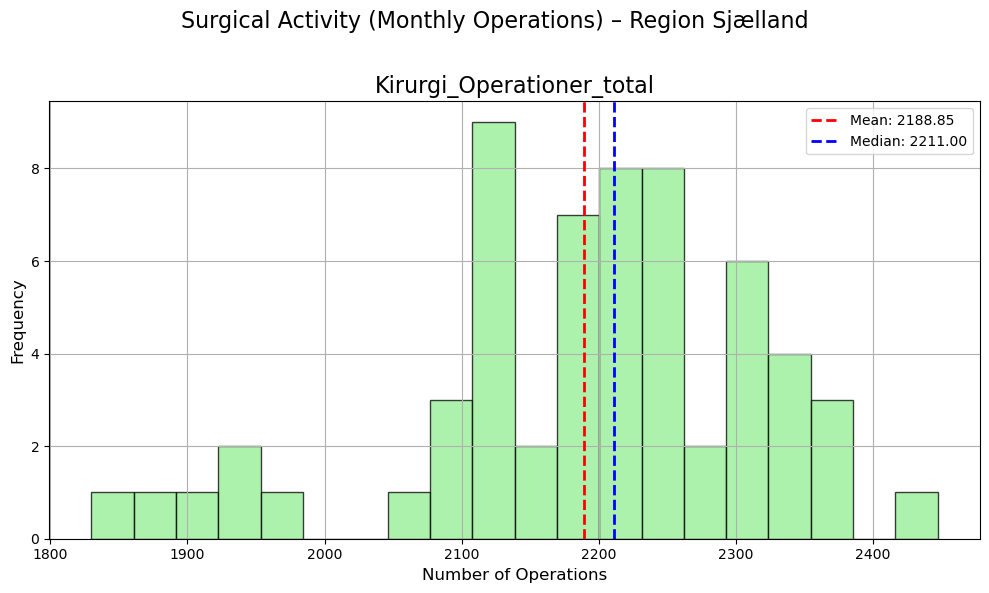

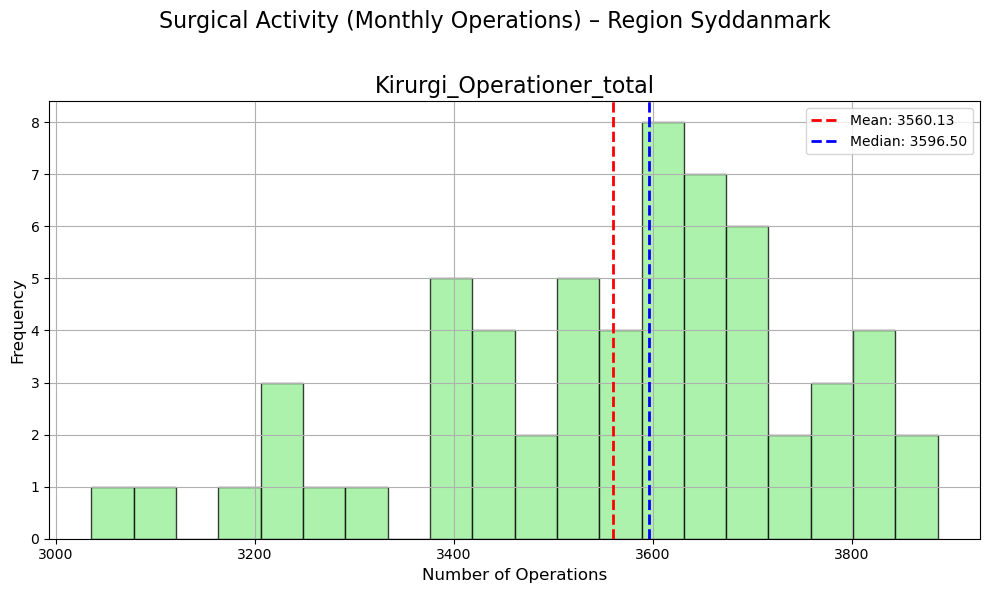

In [13]:
# Shows the distribution of total monthly surgical operations per region.
# Helps identify which regions have higher or lower activity levels or larger fluctuations.

for r in regions:
    sub = all_kir_cleaned[all_kir_cleaned[REGION_COL] == r]
    plot_hosp_histogram(
        sub[["Kirurgi_Operationer_total"]],
        title=f"Surgical Activity (Monthly Operations) – {r}",
        x_label="Number of Operations",
        y_label="Frequency",
        color="lightgreen",
    )

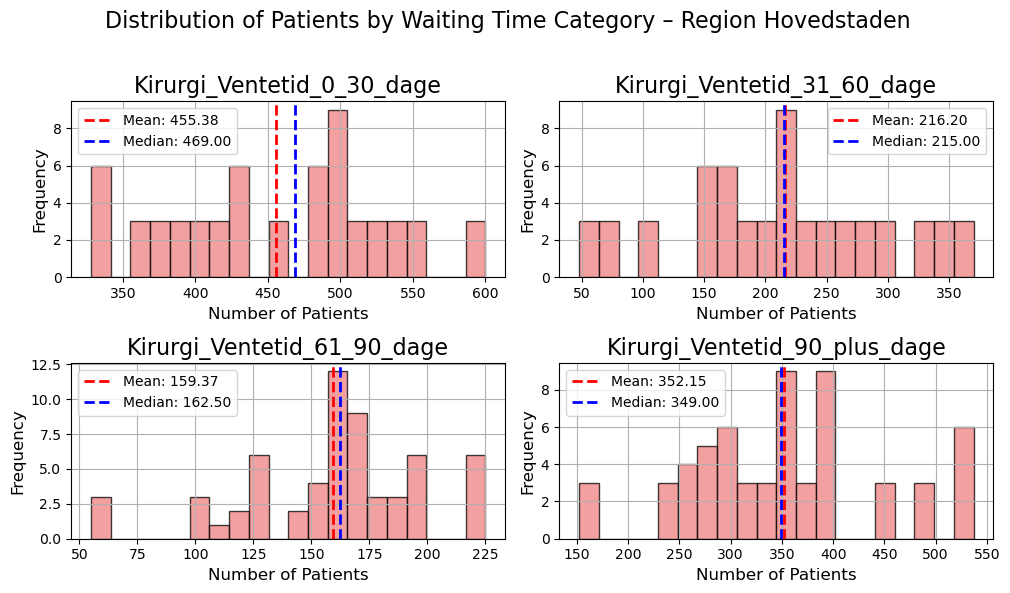

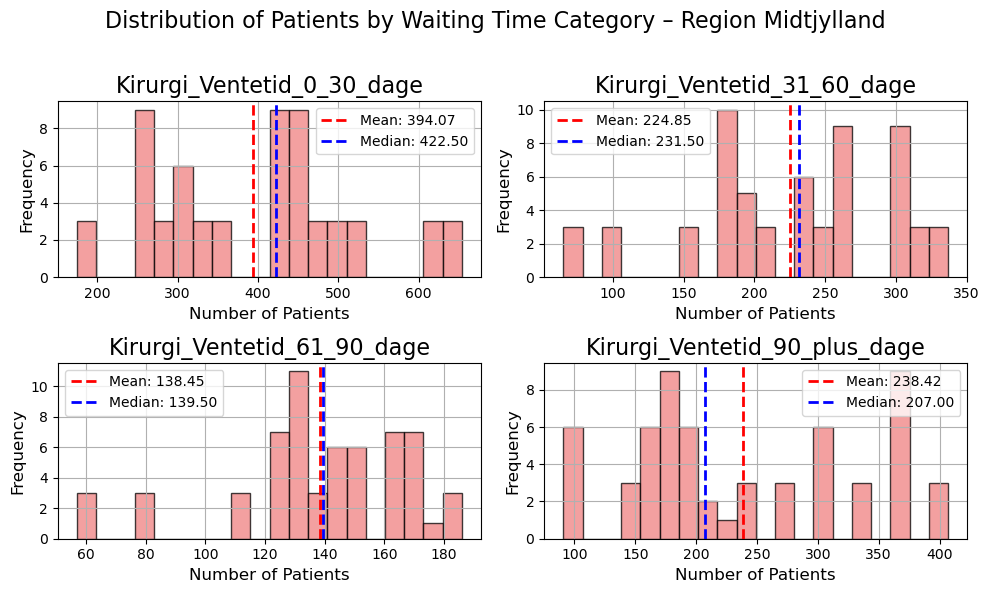

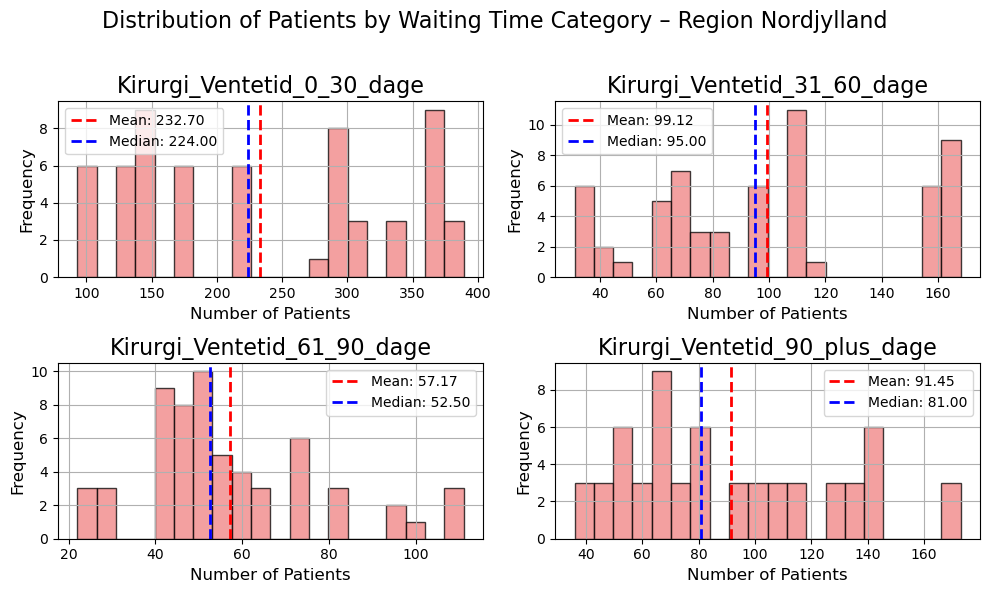

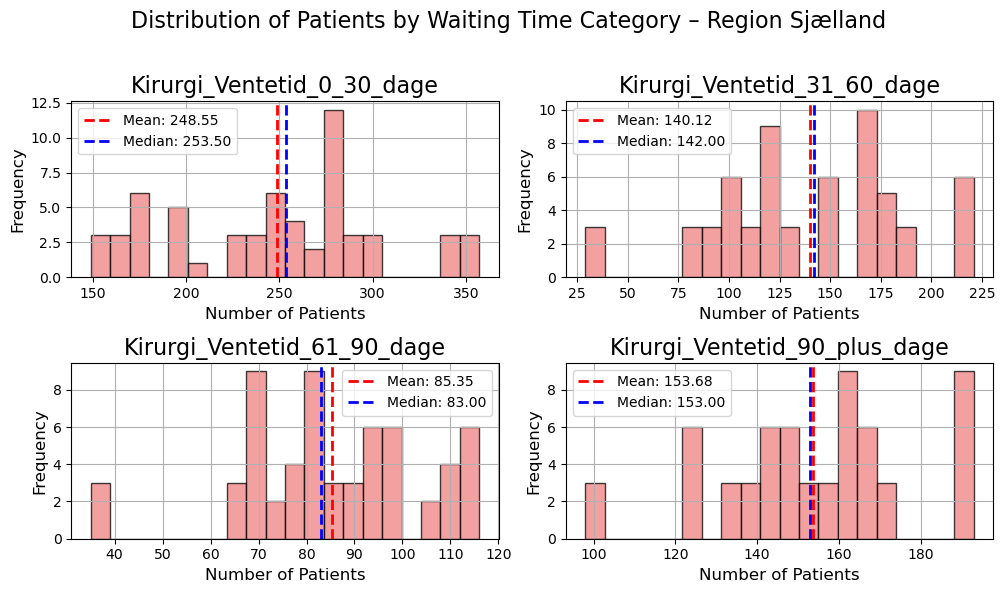

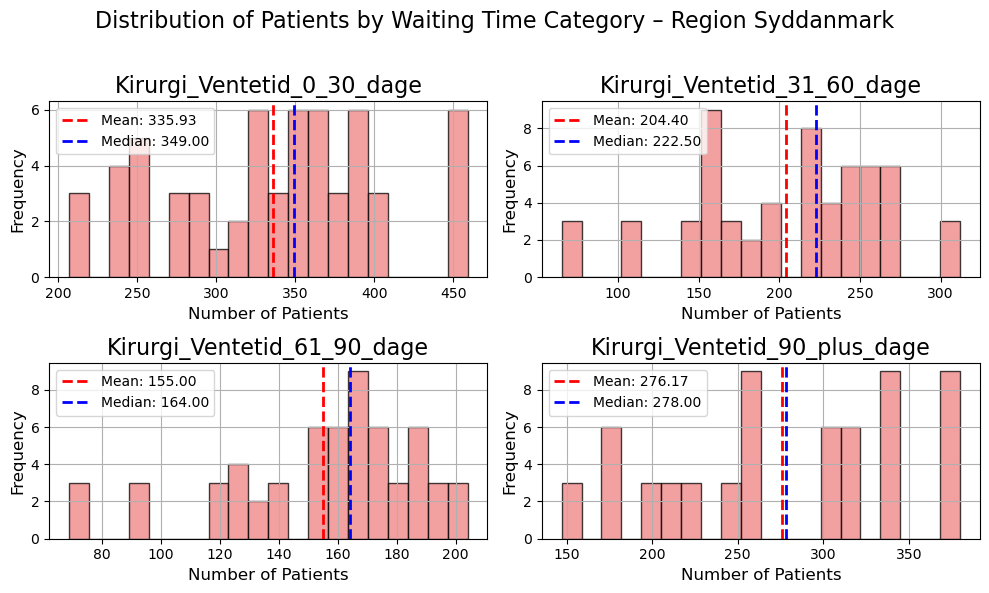

In [14]:
# Displays the number of patients within each waiting time category for each region.
# Helps compare whether some regions have more patients in the long waiting categories (e.g., 90+ days).

for r in regions:
    sub = all_kir_cleaned[all_kir_cleaned[REGION_COL] == r]
    plot_hosp_histogram(
        sub[
            [
                "Kirurgi_Ventetid_0_30_dage",
                "Kirurgi_Ventetid_31_60_dage",
                "Kirurgi_Ventetid_61_90_dage",
                "Kirurgi_Ventetid_90_plus_dage",
            ]
        ],
        title=f"Distribution of Patients by Waiting Time Category – {r}",
        x_label="Number of Patients",
        y_label="Frequency",
        color="lightcoral",
    )

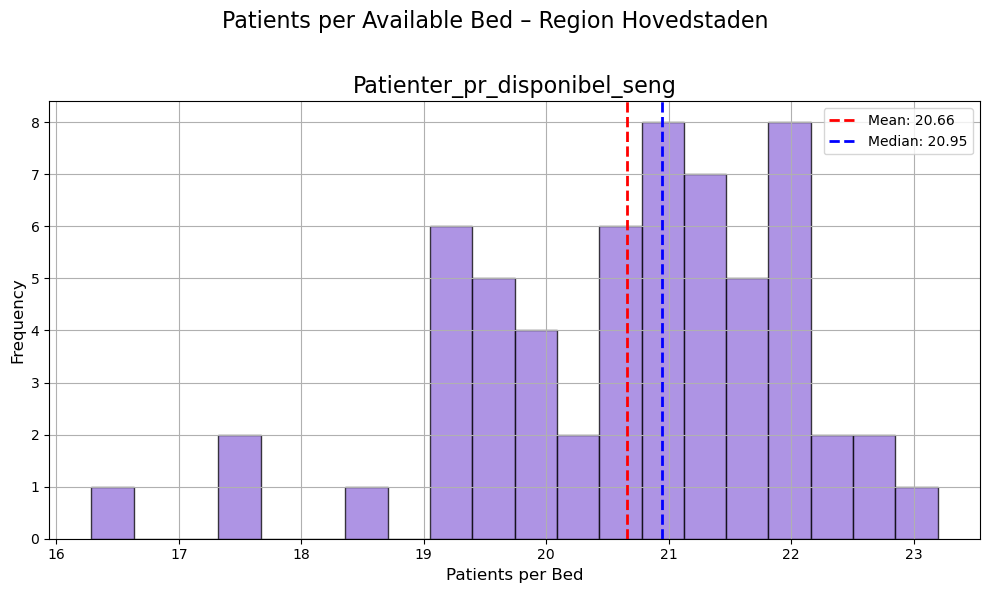

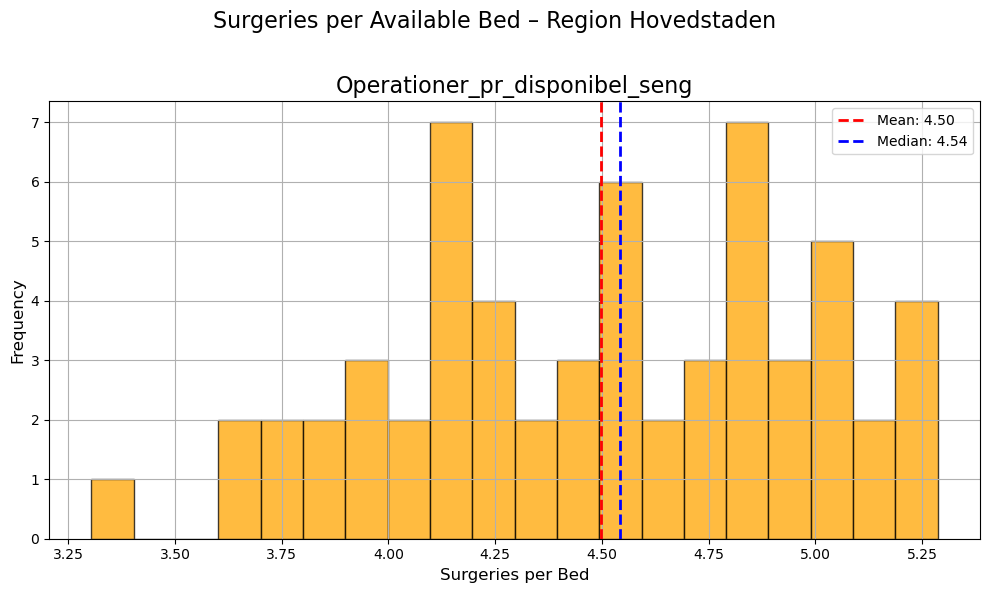

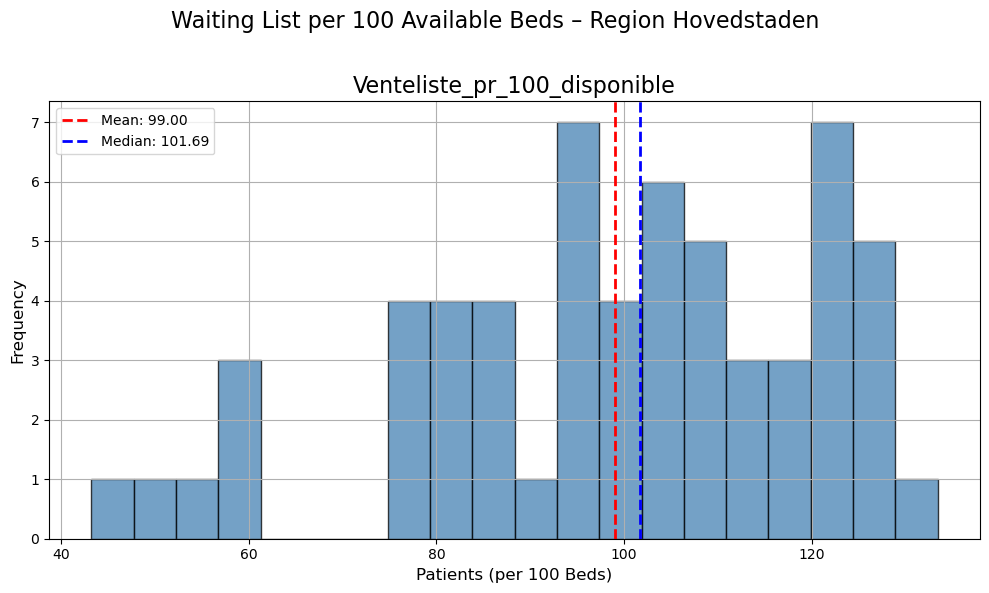

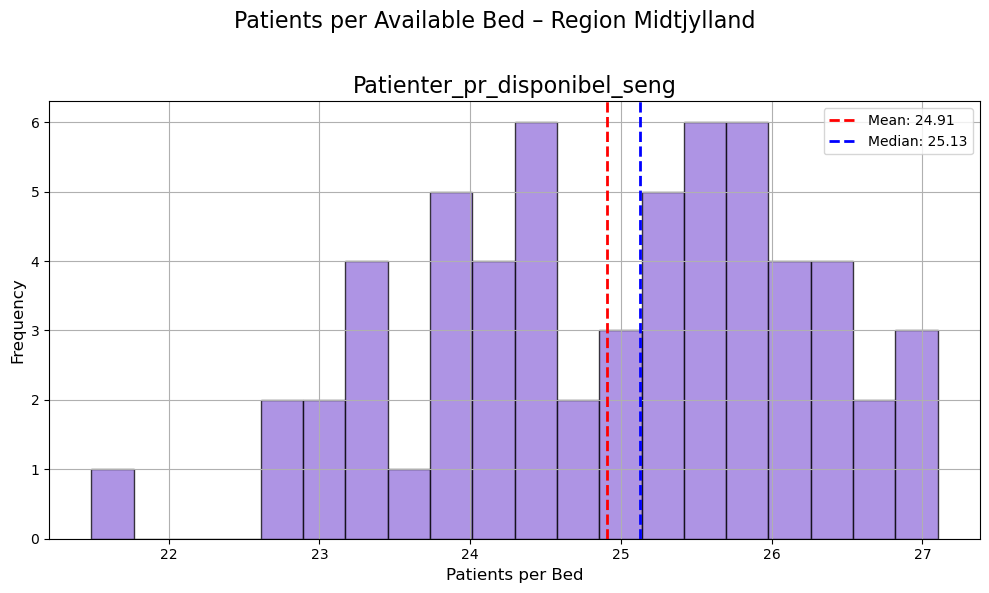

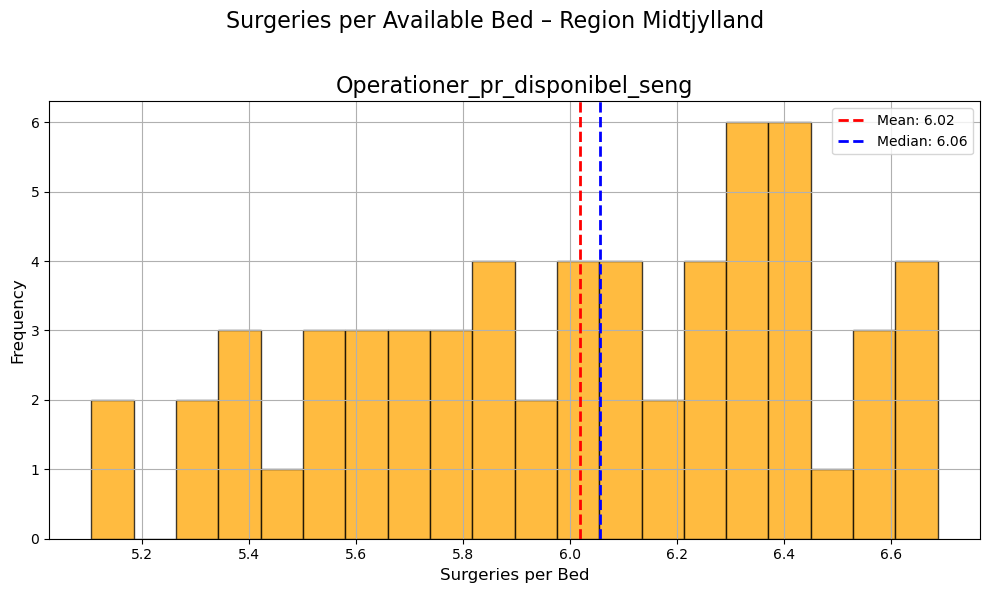

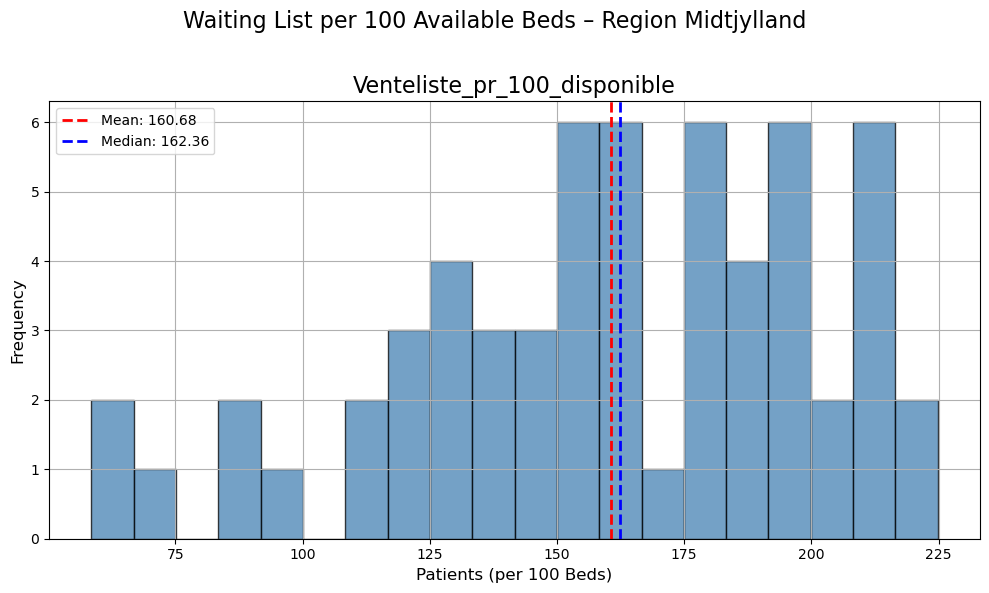

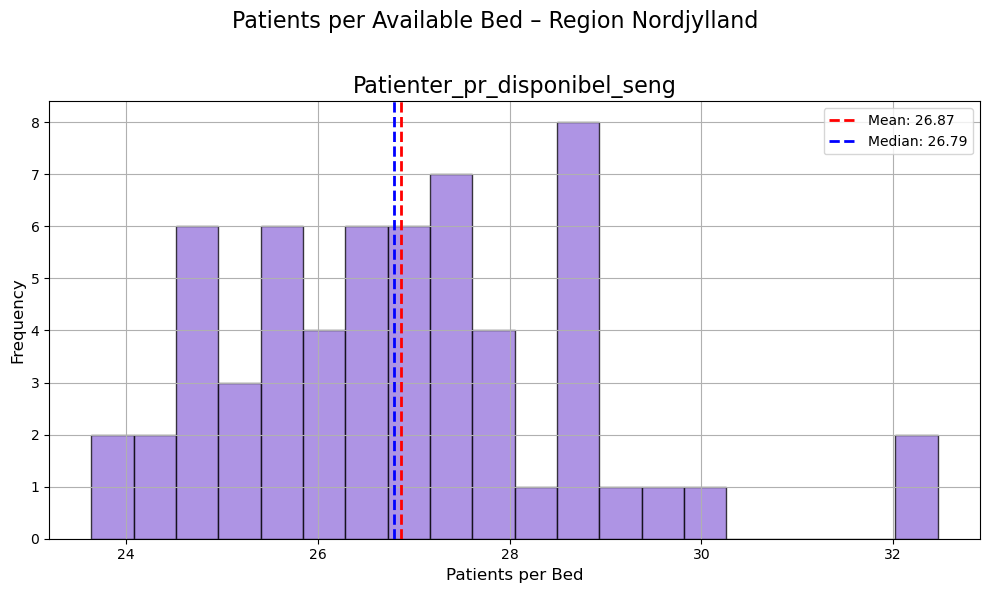

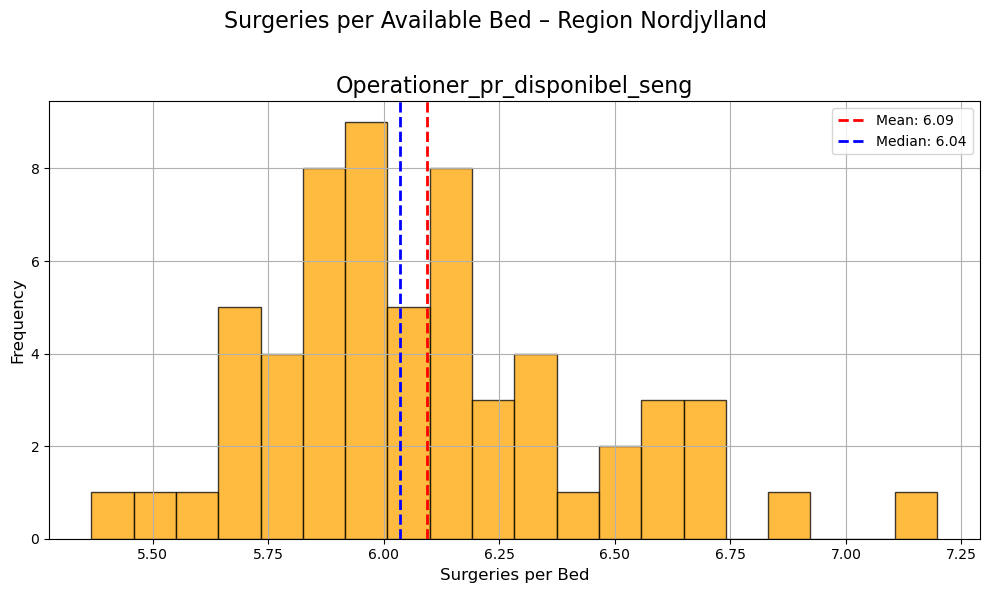

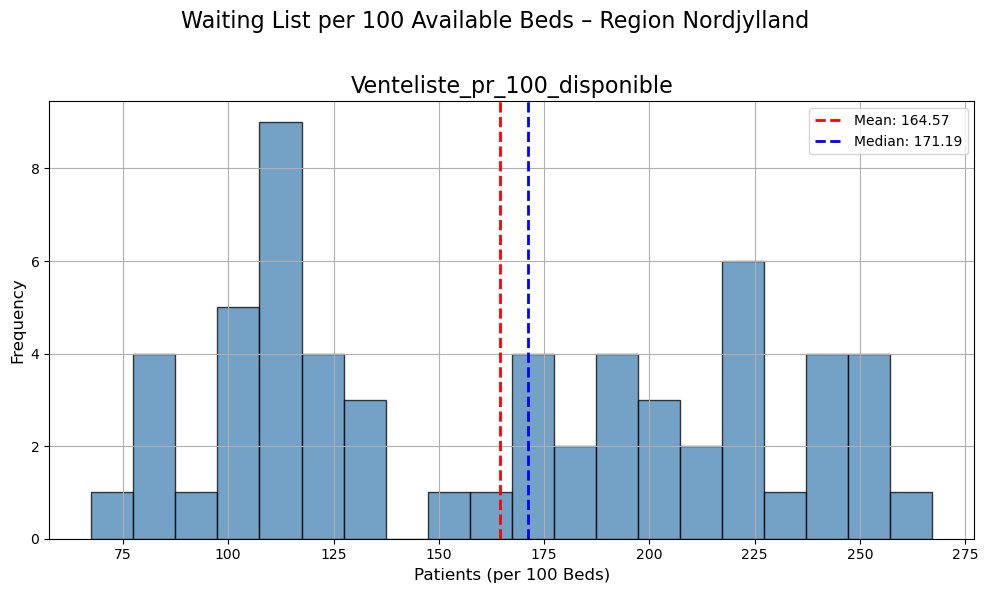

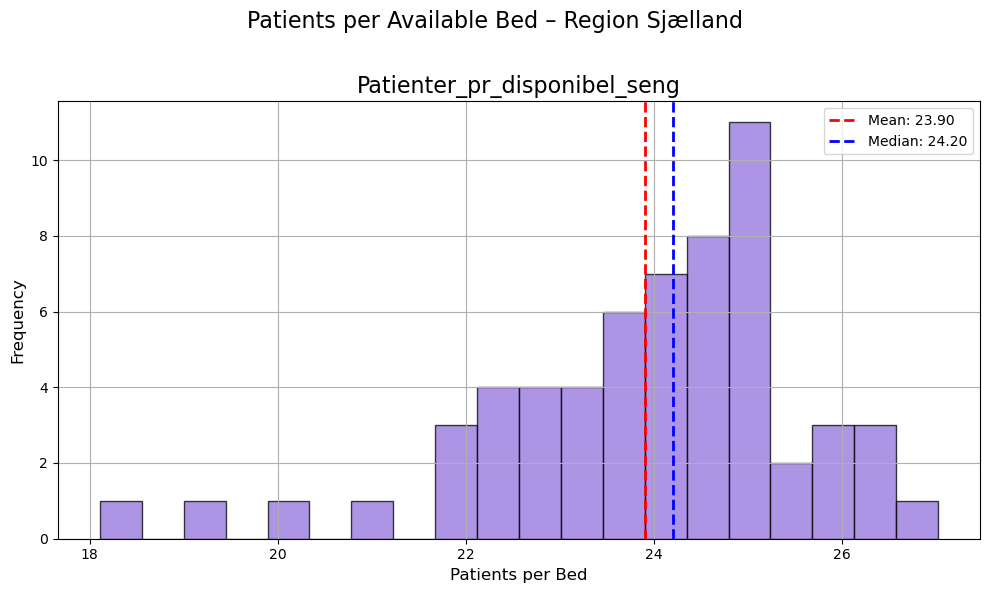

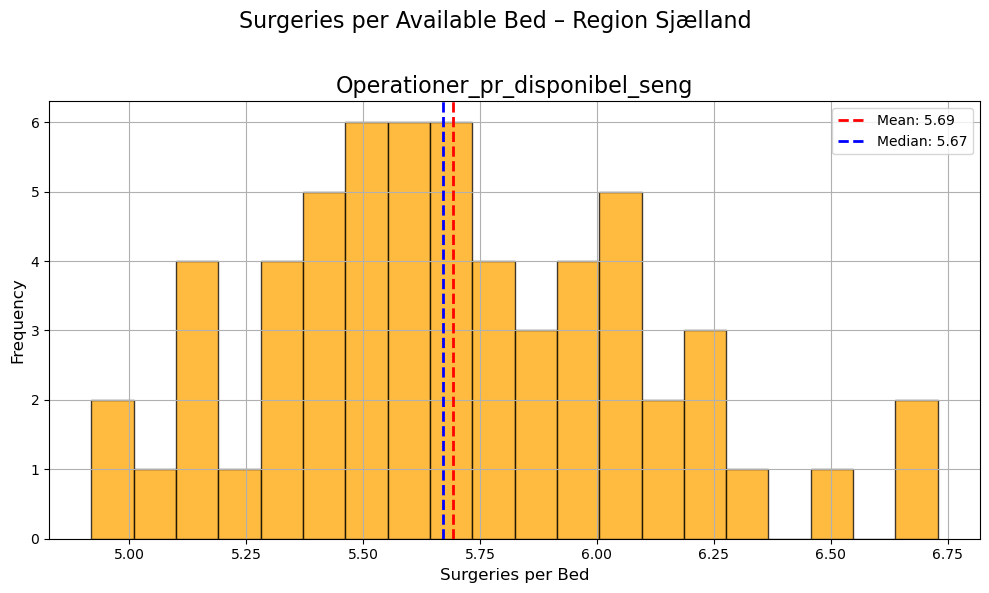

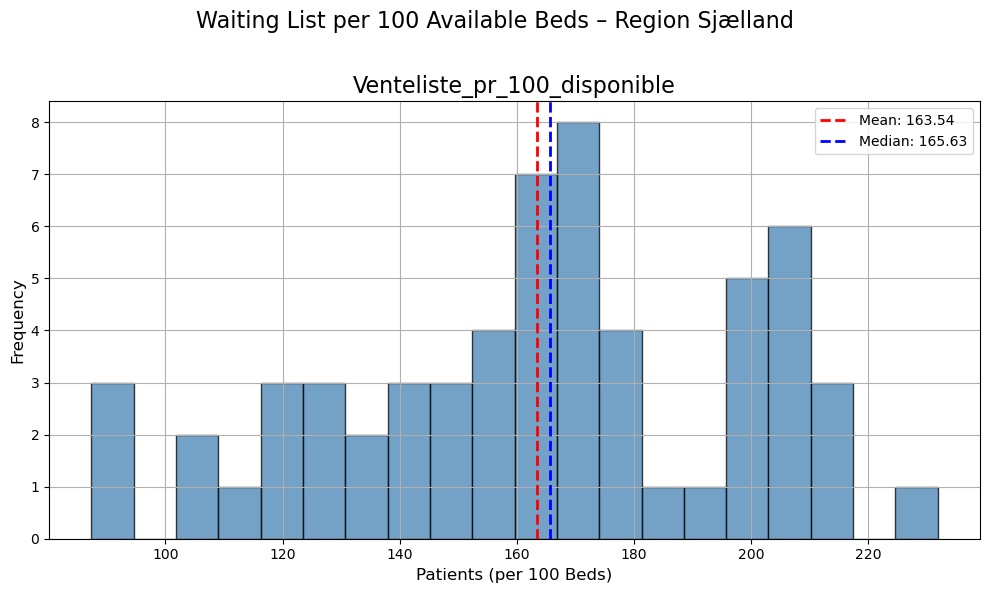

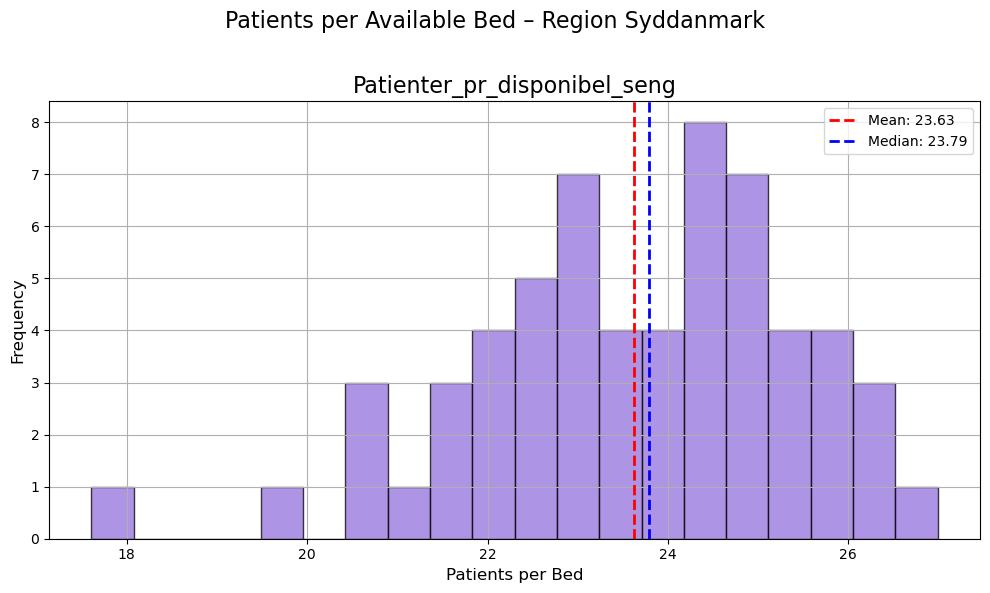

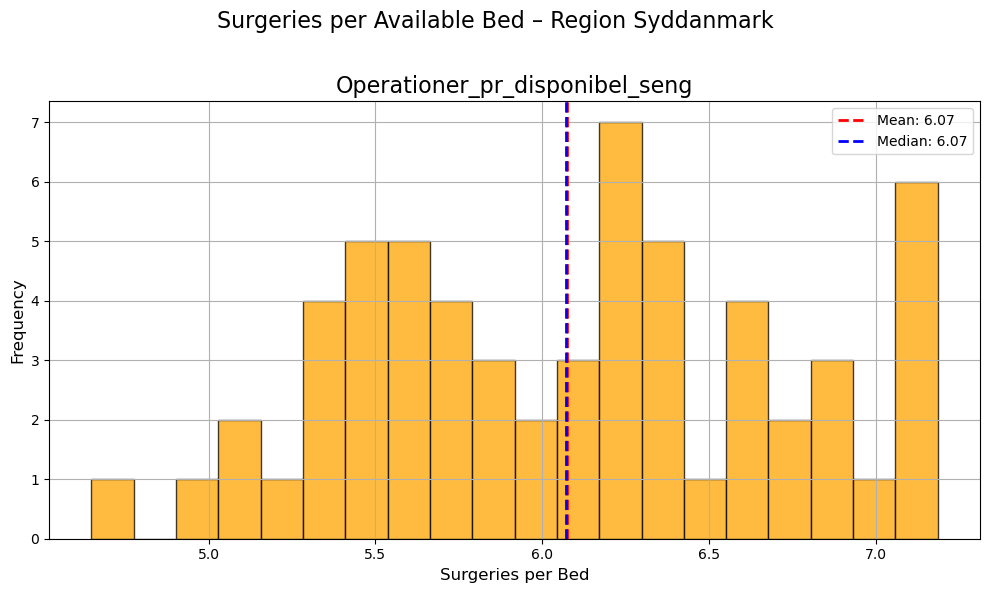

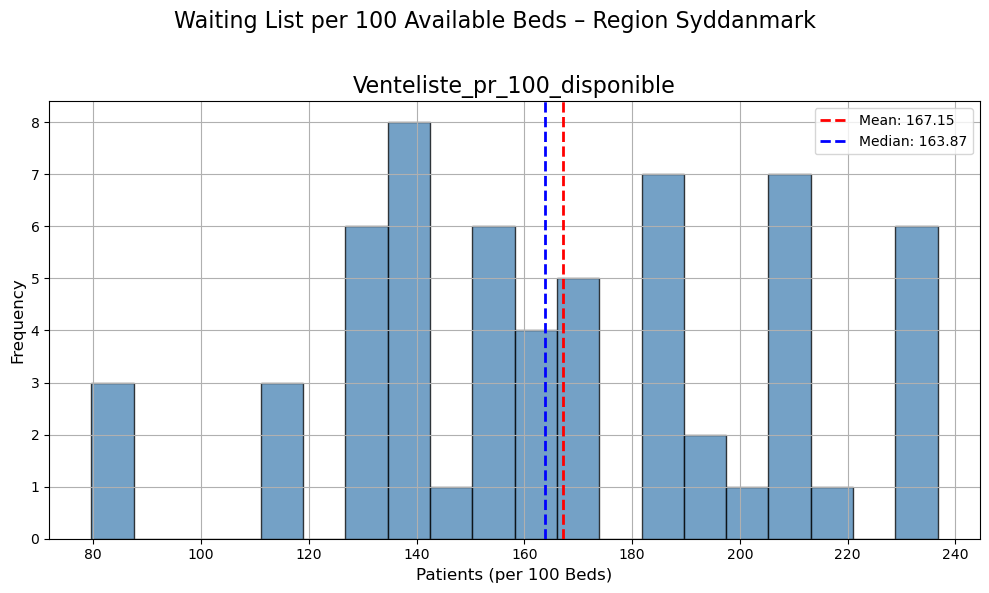

In [15]:
# These histograms visualize the derived KPIs, showing the relationship between activity, capacity, and waiting times.
# They reveal how efficiently each region utilizes its surgical capacity.

for r in regions:
    sub = all_kir_cleaned[all_kir_cleaned[REGION_COL] == r]

    # Patients per available bed: system load relative to capacity
    plot_hosp_histogram(
        sub[["Patienter_pr_disponibel_seng"]],
        title=f"Patients per Available Bed – {r}",
        x_label="Patients per Bed",
        y_label="Frequency",
        color="mediumpurple",
    )

    # Surgeries per available bed: how productive each region is with its capacity
    plot_hosp_histogram(
        sub[["Operationer_pr_disponibel_seng"]],
        title=f"Surgeries per Available Bed – {r}",
        x_label="Surgeries per Bed",
        y_label="Frequency",
        color="orange",
    )

    # Waiting list per 100 available beds: backlog intensity relative to capacity
    plot_hosp_histogram(
        sub[["Venteliste_pr_100_disponible"]],
        title=f"Waiting List per 100 Available Beds – {r}",
        x_label="Patients (per 100 Beds)",
        y_label="Frequency",
        color="steelblue",
    )

In [16]:
# Checking our DataFrame to make sure how it looks
display(all_kir_cleaned)

,Dato,Region,Kirurgi_Operationer_total,Disponible_senge,Normerede_senge,Belægningsgrad_disponible,Belægningsgrad_normerede,Patienter_total,År,Måned,Kirurgi_Ventetid_0_30_dage,Kirurgi_Ventetid_31_60_dage,Kirurgi_Ventetid_61_90_dage,Kirurgi_Ventetid_90_plus_dage,Kirurgi_Venteliste_total,Patienter_pr_disponibel_seng,Operationer_pr_disponibel_seng,Venteliste_pr_100_disponible
0,2020-01-01,Region Syddanmark,3592,671.0,675.0,77.0,76.0,15927.0,2020,1,323,241,153,147,864,23.736215,5.353204,128.763040
1,2020-01-01,Region Nordjylland,1621,302.0,329.0,95.0,87.0,8893.0,2020,1,146,96,49,37,328,29.447020,5.367550,108.609272
2,2020-01-01,Region Hovedstaden,4960,1501.0,1584.0,67.0,64.0,31201.0,2020,1,510,248,225,268,1251,20.786809,3.304464,83.344437
3,2020-01-01,Region Sjælland,2115,413.0,443.0,74.0,69.0,9455.0,2020,1,201,153,94,156,604,22.893462,5.121065,146.246973
4,2020-01-01,Region Midtjylland,3758,710.0,741.0,81.0,78.0,17906.0,2020,1,442,260,124,96,922,25.219718,5.292958,129.859155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2024-12-01,Region Sjælland,2295,345.0,442.0,80.0,63.0,8608.0,2024,12,357,175,107,161,800,24.950725,6.652174,231.884058
296,2024-12-01,Region Midtjylland,3591,572.0,646.0,77.0,68.0,13668.0,2024,12,653,317,130,186,1286,23.895105,6.277972,224.825175
297,2024-12-01,Region Hovedstaden,5233,1057.0,1353.0,67.0,53.0,22044.0,2024,12,600,369,176,265,1410,20.855251,4.950804,133.396405
298,2024-12-01,Region Nordjylland,1631,277.0,321.0,78.0,68.0,6726.0,2024,12,366,166,57,65,654,24.281588,5.888087,236.101083


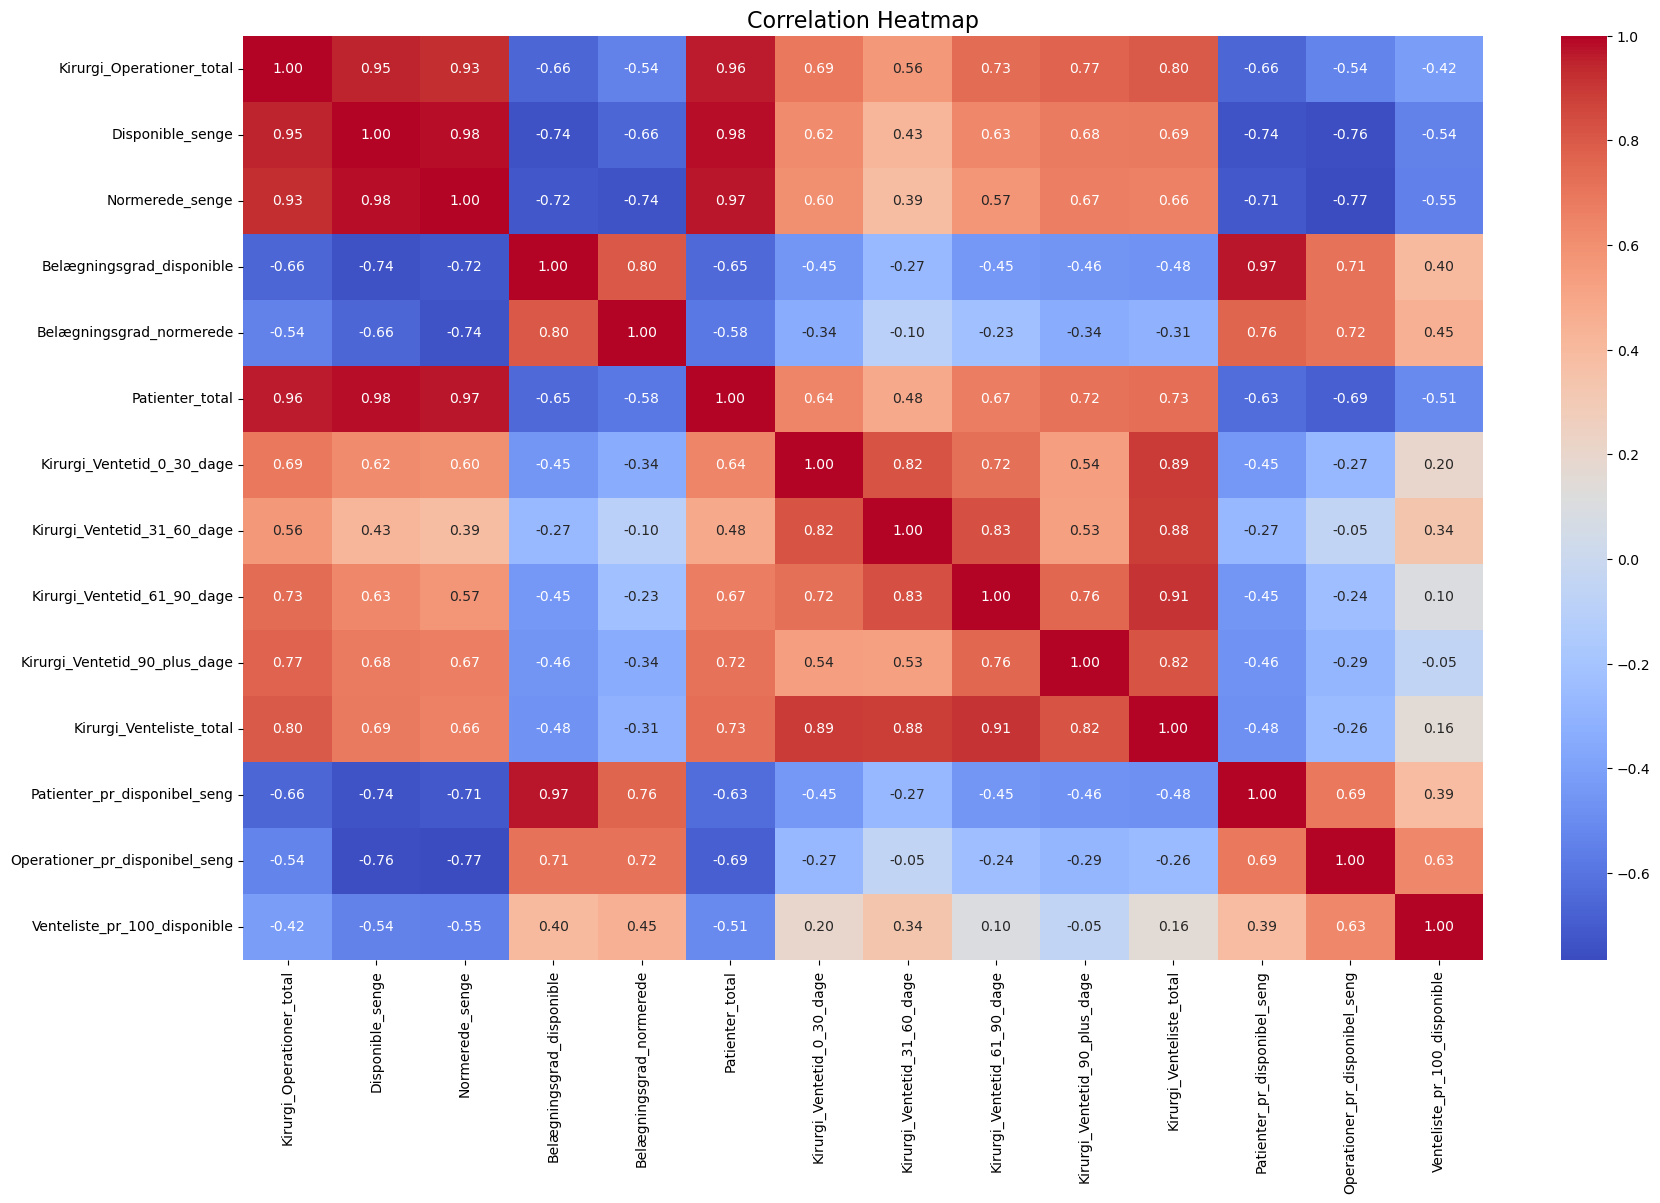

In [17]:
from hosp_heatmap import plot_hosp_heatmap

plot_hosp_heatmap(all_kir_cleaned)

c:\Users\Asim\Downloads\MP1\EXAM\src\hosp_scatp.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.scatterplot(data=df_num, x=x_col, y=y_col, hue=hue, palette=palette, alpha=alpha)


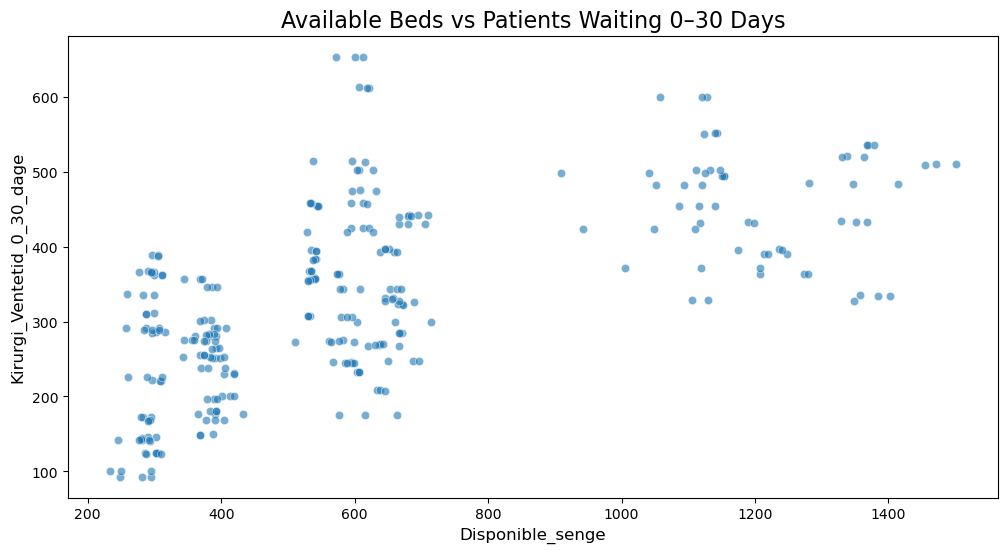

In [18]:
from hosp_scatp import plot_hosp_scatter

plot_hosp_scatter(all_kir_cleaned, title = "Available Beds vs Patients Waiting 0–30 Days", x_col = "Disponible_senge", y_col = "Kirurgi_Ventetid_0_30_dage")

#### Available Beds vs Patients Waiting 0–30 Days

This scatterplot shows how the number of available beds (Disponible_senge) relates to patients waiting 0–30 days.

The heatmap indicated a moderate positive correlation, meaning hospitals with more available beds tend to have slightly more short-term waiting patients.

However, the scatterplot reveals that this relationship isn’t perfectly linear — other factors likely affect waiting time distribution.

c:\Users\Asim\Downloads\MP1\EXAM\src\hosp_scatp.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.scatterplot(data=df_num, x=x_col, y=y_col, hue=hue, palette=palette, alpha=alpha)


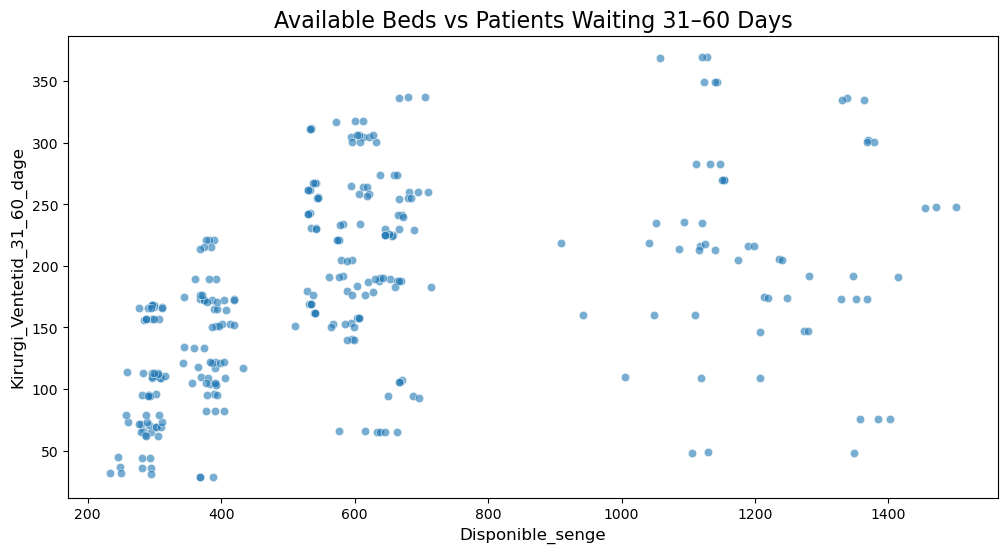

In [19]:
plot_hosp_scatter(all_kir_cleaned, title = "Available Beds vs Patients Waiting 31–60 Days", x_col = "Disponible_senge", y_col = "Kirurgi_Ventetid_31_60_dage")

#### Available Beds vs Patients Waiting 31–60 Days

Here, we compare available beds with patients waiting 31–60 days.

The correlation in the heatmap was weaker, and the scatterplot confirms this — the points are more dispersed, suggesting no strong direct relationship.

This implies that medium-term waiting lists may depend more on operational efficiency or scheduling rather than pure bed availability.

c:\Users\Asim\Downloads\MP1\EXAM\src\hosp_scatp.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.scatterplot(data=df_num, x=x_col, y=y_col, hue=hue, palette=palette, alpha=alpha)


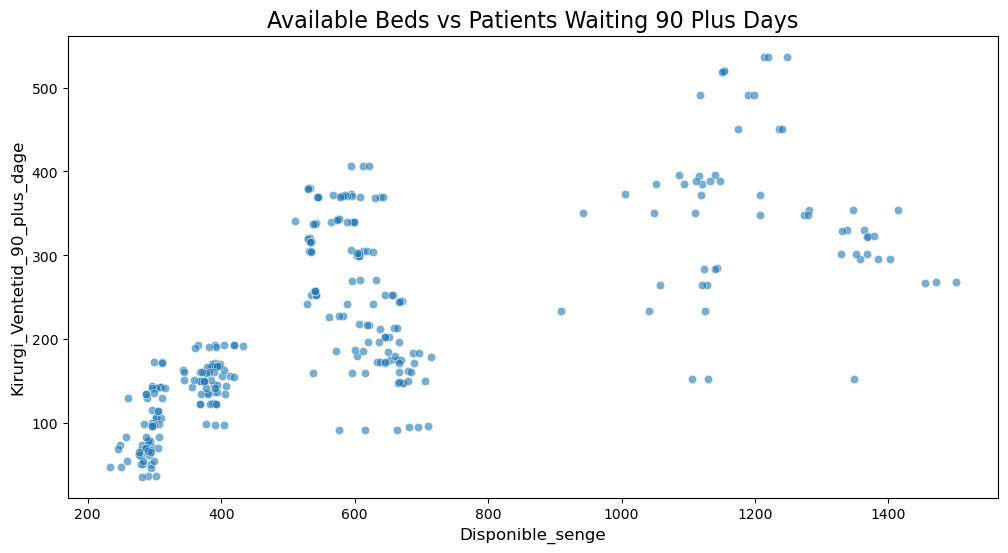

In [20]:
plot_hosp_scatter(all_kir_cleaned, title = "Available Beds vs Patients Waiting 90 Plus Days", x_col = "Disponible_senge", y_col = "Kirurgi_Ventetid_90_plus_dage")

#### Available Beds vs Patients Waiting 90+ Days

This plot examines longer waiting times.

The heatmap suggested a slightly stronger correlation than the 31–60 day case, and the scatterplot shows a faint upward trend.

Hospitals with higher bed capacity might still accumulate long-term waiting patients — possibly due to higher patient inflow.

c:\Users\Asim\Downloads\MP1\EXAM\src\hosp_scatp.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.scatterplot(data=df_num, x=x_col, y=y_col, hue=hue, palette=palette, alpha=alpha)


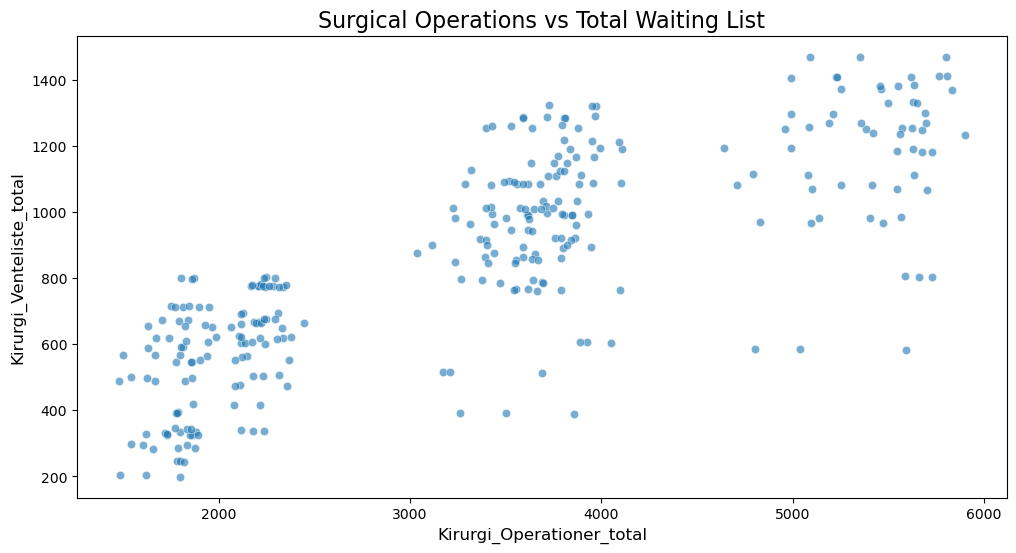

In [21]:
plot_hosp_scatter(all_kir_cleaned, title = "Surgical Operations vs Total Waiting List", x_col = "Kirurgi_Operationer_total", y_col = "Kirurgi_Venteliste_total")

#### Surgical Operations vs Total Waiting List

This scatterplot explores the relationship between surgical operations (Kirurgi_Operationer_total) and the total waiting list (Kirurgi_Venteliste_total).

The heatmap showed a very strong positive correlation, and the scatterplot clearly confirms this: as surgical operations increase, so does the waiting list.

This suggests that regions with more surgeries also handle larger patient volumes overall — likely reflecting their higher capacity.

c:\Users\Asim\Downloads\MP1\EXAM\src\hosp_scatp.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.scatterplot(data=df_num, x=x_col, y=y_col, hue=hue, palette=palette, alpha=alpha)


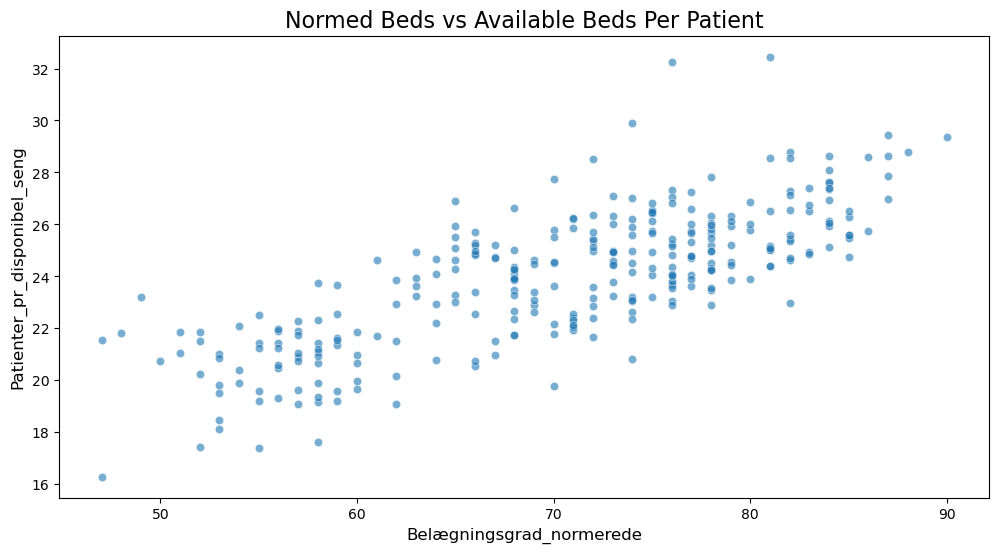

In [22]:
plot_hosp_scatter(all_kir_cleaned, title = "Normed Beds vs Available Beds Per Patient", x_col = "Belægningsgrad_normerede", y_col = "Patienter_pr_disponibel_seng")

#### Bed Capacity vs Available Beds Per Patient

Finally, this plot compares bed capacity utilization (Belægningsgrad_normerede) with patients per available bed.

The heatmap showed a strong positive correlation, and the scatterplot confirms a clear upward linear trend.

This indicates that when bed capacity utilization rises, the number of patients per available bed also increases — meaning hospitals with higher bed use handle more patients relative to capacity.

### Summary

Together, these scatterplots visually validate the heatmap’s key findings:

Strong linear relationships (operations vs waiting list, normed beds vs patients per bed).

Weaker or moderate correlations (available beds vs waiting times).

The combination of both visual and numerical methods strengthens the conclusion that capacity and patient load are closely related, though waiting times are influenced by more than just bed availability.

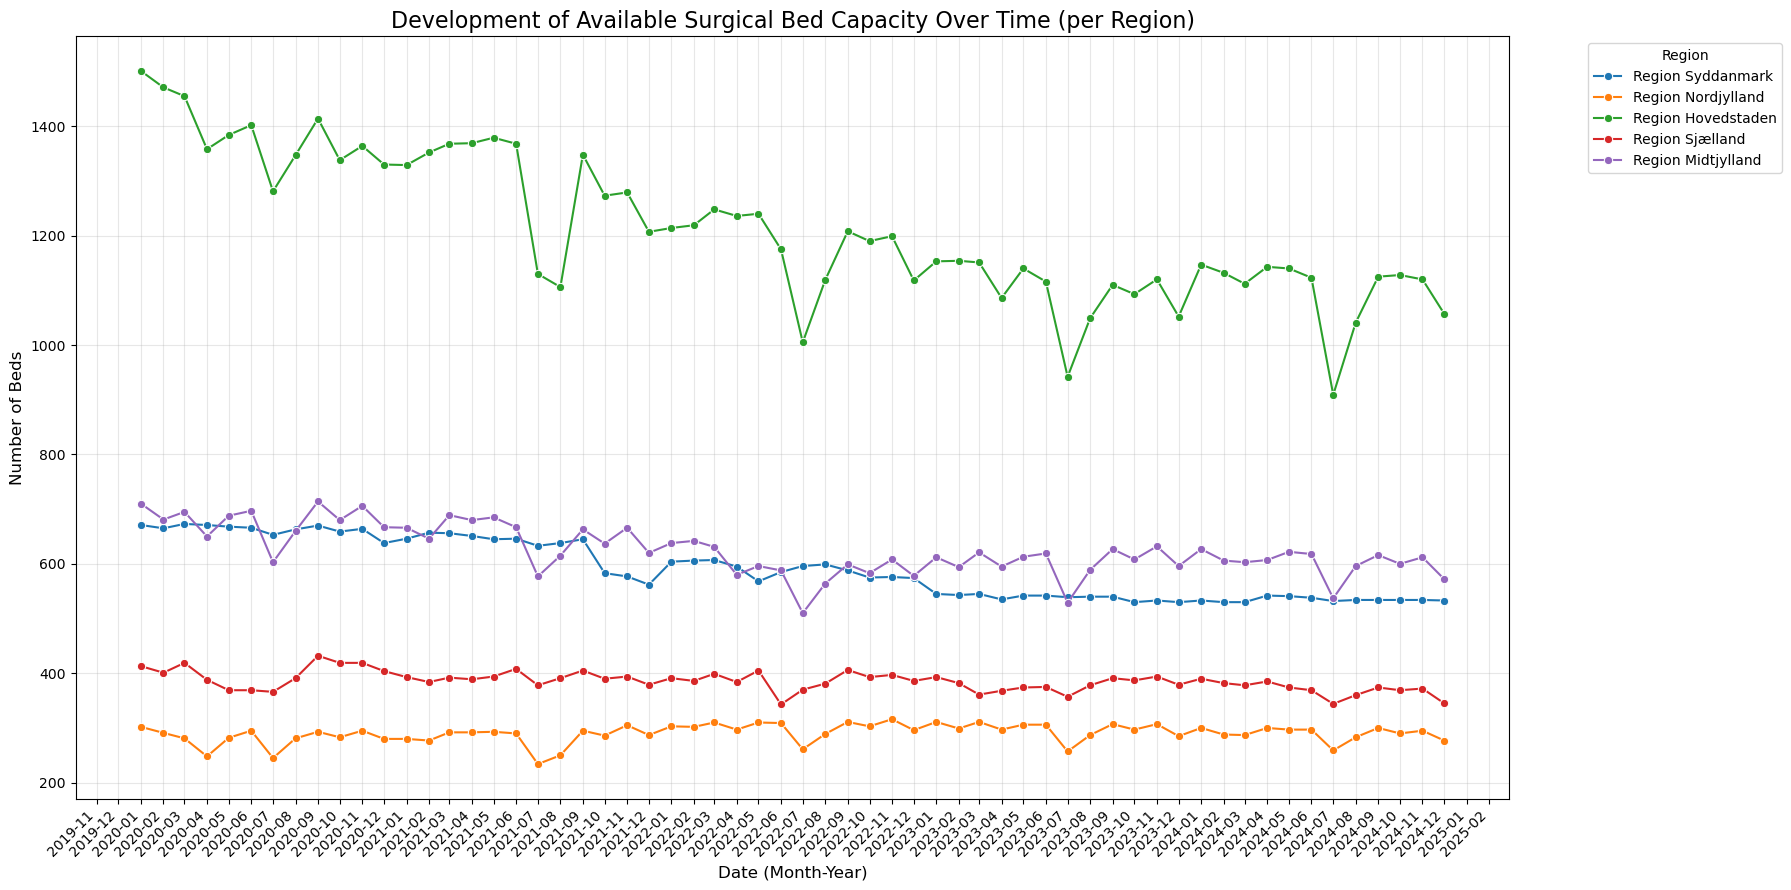

In [23]:
from hosp_lineplot import plot_capacity_over_time

plot_capacity_over_time(
    all_kir_cleaned,
    y_cols=["Disponible_senge"],
    title="Development of Available Surgical Bed Capacity Over Time (per Region)"
)

# The observed decrease in July–August may be explained by reduced staffing levels caused by vacations and public holidays.

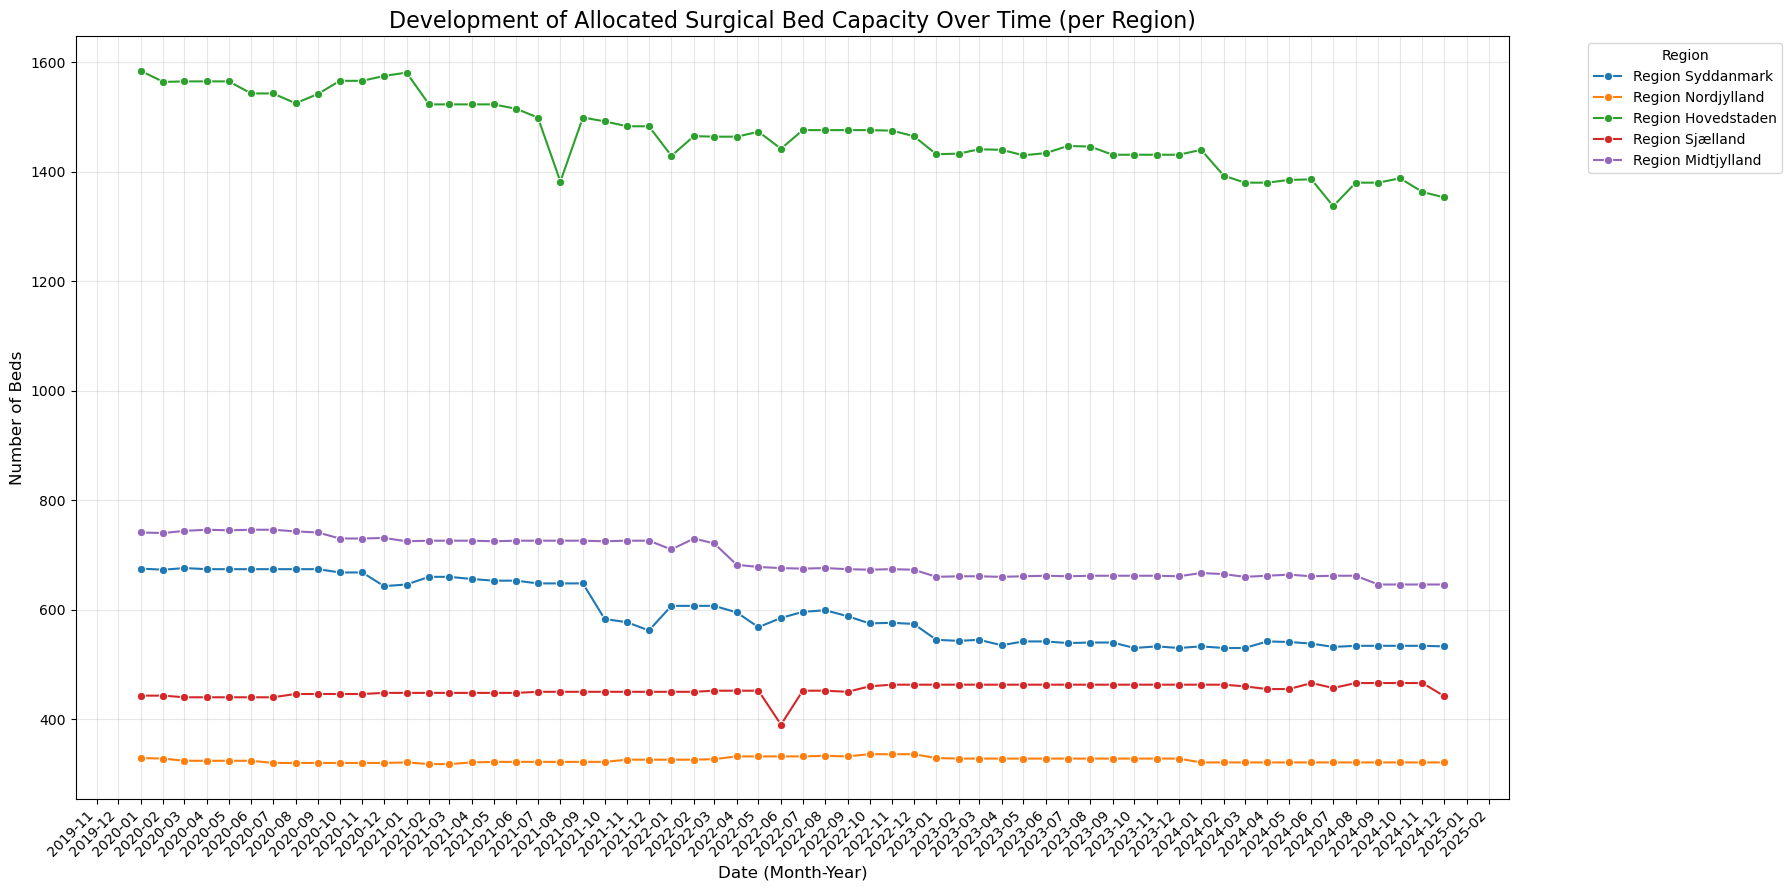

In [24]:
from hosp_lineplot import plot_capacity_over_time

plot_capacity_over_time(
    all_kir_cleaned,
    y_cols=["Normerede_senge"],
    title="Development of Allocated Surgical Bed Capacity Over Time (per Region)"
)

# Small decreases are again observed in July–August, but overall the trend remains steady with a slight downward direction.

In [25]:
plot_capacity_over_time(
    all_kir_cleaned,
    y_cols=["Kirurgi_Operationer_total"],
    y_label="Total Surgical Operations",
    title="Development of Surgical Operations Over Time (per Region)"
)

TypeError: plot_capacity_over_time() got an unexpected keyword argument 'y_label'

In [ ]:
plot_capacity_over_time(
    all_kir_cleaned,
    y_cols=["Kirurgi_Venteliste_total"],
    y_label="Total Surgical Waiting List",
    title="Development of Surgical Waiting List Over Time (per Region)"
)

In [ ]:
from hosp_boxplot import plot_hosp_boxplots

plot_hosp_boxplots(all_kir_cleaned)

#### Note on Outliers 
We observed outliers in both available and normed beds. These outliers primarily come from Region Hovedstaden, whose capacity is significantly higher than that of other regions. Therefore, we consider these values representative rather than erroneous, and we decided not to exclude them.

In [ ]:
# --- Feature Engineering ---
all_kir_cleaned["År"] = all_kir_cleaned["Dato"].dt.year
all_kir_cleaned["Måned"] = all_kir_cleaned["Dato"].dt.month
all_kir_cleaned["Quarter"] = all_kir_cleaned["Dato"].dt.to_period("Q")

# For modeling later
all_kir_encoded = pd.get_dummies(all_kir_cleaned, columns=["Region"], drop_first=True)

display(all_kir_encoded.head())


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import pandas as pd

# --- Prepare data ---
df_model = all_kir_encoded.drop(columns=["Dato", "Quarter"], errors="ignore")

# --- Choose target and features ---
y = df_model["Kirurgi_Ventetid_90_plus_dage"]
X = df_model.drop(columns=[
    "Kirurgi_Ventetid_90_plus_dage",
    "Kirurgi_Venteliste_total",
    "Kirurgi_Ventetid_0_30_dage",
    "Kirurgi_Ventetid_31_60_dage",
    "Kirurgi_Ventetid_61_90_dage"
])

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# --- Train model ---
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# --- Evaluate ---
y_pred = linreg.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R²:", metrics.r2_score(y_test, y_pred))

# --- Coefficients ---
coef_table = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": linreg.coef_
}).sort_values(by="Coefficient", ascending=False)

print(coef_table.head(10))


#### Multiple Linear Regression Analysis of Factors Affecting 90+ Day Surgical Waiting Times

A multiple linear regression model predicting patients waiting 90+ days achieved an R² of 0.61, suggesting moderate explanatory power.

The strongest predictors were surgical activity per available bed (+8.06) and bed occupancy (+3.91), both positively associated with longer waiting times, indicating capacity strain.

Conversely, higher numbers of normed or available beds were associated with shorter waiting times (−0.12 and −0.29 respectively), supporting the hypothesis that increased capacity reduces delays.

Seasonal and regional effects also appear relevant, as later months showed slightly reduced long waits.

In [ ]:
df_model["HighLoad"] = (
    df_model["Kirurgi_Ventetid_90_plus_dage"] >
    df_model["Kirurgi_Ventetid_90_plus_dage"].quantile(0.75)
).astype(int)

y = df_model["HighLoad"]
X = df_model.drop(columns=["HighLoad"])

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = RandomForestClassifier(max_depth=6, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal Load", "High Load"],
            yticklabels=["Normal Load", "High Load"])
plt.title("Confusion Matrix – Predicting High Load Months")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(y="Feature", x="Importance", data=feat_imp.head(10), palette="viridis")
plt.title("Top 10 Predictors of High Load (90+ Day Waiting Time)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

df_cluster = df_model.select_dtypes(include=[np.number]).fillna(0)

X = df_cluster.values

# --- Elbow method ---
distortions = []
K = range(2, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X)
    distortions.append(model.inertia_)

plt.plot(K, distortions, 'bx-')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Distortion)")
plt.show()

In [ ]:
# --- Silhouette Score ---
scores = []
for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    scores.append(score)

plt.plot(K, scores, 'bx-')
plt.title("Silhouette Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
# --- Clustering prep (scale features and fit KMeans) ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose numeric features (drop identifiers/time/leakage if present)
cluster_feats = [
    "Disponible_senge","Normerede_senge","Belægningsgrad_disponible","Belægningsgrad_normerede",
    "Kirurgi_Operationer_total","Kirurgi_Venteliste_total",
    "Kirurgi_Ventetid_0_30_dage","Kirurgi_Ventetid_31_60_dage","Kirurgi_Ventetid_61_90_dage","Kirurgi_Ventetid_90_plus_dage",
    "Patienter_total","Patienter_pr_disponibel_seng","Operationer_pr_disponibel_seng","Venteliste_pr_100_disponible",
    "År","Måned"
]
cluster_feats = [c for c in cluster_feats if c in all_kir_encoded.columns]

X_raw = all_kir_encoded[cluster_feats].fillna(0).values

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Fit KMeans
k = 3  # adjust if elbow/silhouette suggests otherwise
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X)
centers_scaled = kmeans.cluster_centers_

# Transform centers back to original scale (optional, for profiling)
centers_orig = scaler.inverse_transform(centers_scaled)

print(f"Fitted KMeans with k={k}. Cluster sizes:", np.bincount(labels))


In [ ]:
# --- 2D PCA visualization of clusters ---
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X)
centers2 = pca2.transform(centers_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X2[:,0], X2[:,1], c=labels, s=30, cmap="viridis", alpha=0.8)
plt.scatter(centers2[:,0], centers2[:,1], marker="x", s=200, linewidths=2, color="red", label="Centers")
plt.title("KMeans Clusters (PCA 2D)")
plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True, alpha=0.3)
plt.legend(handles=[
    Line2D([0],[0], marker='o', color='w', label='Points', markerfacecolor='#4c78a8', markersize=8),
    Line2D([0],[0], marker='x', color='red', label='Centers', markersize=10, linewidth=2)
])
plt.tight_layout()
plt.show()


In [ ]:
# --- 3D PCA visualization of clusters ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

pca3 = PCA(n_components=3, random_state=42)
X3 = pca3.fit_transform(X)
centers3 = pca3.transform(centers_scaled)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection="3d")
ax.set_title("KMeans Clusters (PCA 3D)")

ax.scatter(X3[:,0], X3[:,1], X3[:,2], c=labels, cmap="viridis", s=15, alpha=0.8)
ax.scatter(centers3[:,0], centers3[:,1], centers3[:,2], marker="x", s=200, linewidths=2, color="red")

ax.set_xlabel(f"PC1 ({pca3.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca3.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_zlabel(f"PC3 ({pca3.explained_variance_ratio_[2]*100:.1f}%)")

plt.tight_layout()
plt.show()


In [ ]:
# --- Profile clusters in original feature space ---
prof = pd.DataFrame(centers_orig, columns=cluster_feats)
prof["Cluster"] = range(k)

# Add counts per cluster
counts = pd.Series(labels).value_counts().sort_index().rename("Count")
prof = prof.join(counts, on="Cluster")

# Optional: region composition per cluster
tmp = all_kir_encoded.copy()
tmp["Cluster"] = labels
region_cols = [c for c in tmp.columns if c.startswith("Region_")]
region_mix = tmp.groupby("Cluster")[region_cols].mean().round(2) if region_cols else pd.DataFrame()

print("=== Cluster Centers (original scale) ===")
display(prof.round(2))

if not region_mix.empty:
    print("=== Region share per cluster (approx., from dummies) ===")
    display(region_mix)

In [ ]:
# --- Train a small Decision Tree to explain HighLoad ---
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ensure your HighLoad exists (top 25% 90+ waiting)
df_tree = all_kir_encoded.copy()
if "HighLoad" not in df_tree.columns:
    df_tree["HighLoad"] = (df_tree["Kirurgi_Ventetid_90_plus_dage"] >
                           df_tree["Kirurgi_Ventetid_90_plus_dage"].quantile(0.75)).astype(int)

# Features (drop obvious leak/targets)
drop_cols = [
    "HighLoad","Dato","Quarter",
    "Kirurgi_Venteliste_total",
    "Kirurgi_Ventetid_0_30_dage","Kirurgi_Ventetid_31_60_dage",
    "Kirurgi_Ventetid_61_90_dage","Kirurgi_Ventetid_90_plus_dage"
]
X = df_tree.drop(columns=[c for c in drop_cols if c in df_tree.columns], errors="ignore")
y = df_tree["HighLoad"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=42)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# Quick in-notebook visualization (fallback if Graphviz isn't installed)
plt.figure(figsize=(14,8))
plot_tree(tree_clf, feature_names=X.columns, class_names=["Normal","HighLoad"],
          filled=True, rounded=True, impurity=False, fontsize=9)
plt.title("Decision Tree – Predicting High Load")
plt.tight_layout()
plt.show()


In [ ]:
# --- Export a tree via Graphviz ---
import os
from sklearn import tree
import graphviz

dot = tree.export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=X.columns,
    class_names=["Normal","HighLoad"],
    filled=True, rounded=True, special_characters=True
)

graph = graphviz.Source(dot)
# Change filenames if you want PNG instead
out_base = "hospital_highload_tree"
graph.render(out_base, format="pdf", cleanup=True)

print(f"Graphviz tree saved to: {out_base}.pdf")
